<a href="https://colab.research.google.com/github/kmeng01/rome/blob/main/notebooks/causal_trace.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

In [1]:
# %%bash
# !(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
# cd /content && rm -rf /content/rome
# git clone https://github.com/kmeng01/rome rome > install.log 2>&1
# pip install -r /content/rome/scripts/colab_reqs/rome.txt >> install.log 2>&1
# pip install --upgrade google-cloud-storage >> install.log 2>&1

In [2]:
IS_COLAB = False
try:
    import google.colab, torch, os

    IS_COLAB = True
    os.chdir("/content/rome")
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

## Causal Tracing

A demonstration of the double-intervention causal tracing method.

The strategy used by causal tracing is to understand important
states within a transfomer by doing two interventions simultaneously:

1. Corrupt a subset of the input.  In our paper, we corrupt the subject tokens
   to frustrate the ability of the transformer to accurately complete factual
   prompts about the subject.
2. Restore a subset of the internal hidden states.  In our paper, we scan
   hidden states at all layers and all tokens, searching for individual states
   that carry the necessary information for the transformer to recover its
   capability to complete the factual prompt.

The traces of decisive states can be shown on a heatmap.  This notebook
demonstrates the code for conducting causal traces and creating these heatmaps.

In [3]:
%load_ext autoreload
%autoreload 2

The `experiments.causal_trace` module contains a set of functions for running causal traces.

In this notebook, we reproduce, demonstrate and discuss the interesting functions.

We begin by importing several utility functions that deal with tokens and transformer models.

In [4]:
import os, sys, re, json
import string
import torch
import numpy as np
import copy
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import KnownsDataset

In [5]:
torch.set_grad_enabled(False)

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Now we load a model and tokenizer, and show that it can complete a couple factual statements correctly.

In [5]:
# model_name = "gpt2-xl"  # or "EleutherAI/gpt-j-6B" or "EleutherAI/gpt-neox-20b"
# mt = ModelAndTokenizer(
#     model_name,
#     low_cpu_mem_usage=IS_COLAB,
#     torch_dtype=(torch.float16 if "20b" in model_name else None),
# )

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.99G [00:00<?, ?B/s]

In [ ]:
# mt.model

In [6]:
# predict_token(
#     mt,
#     ["Megan Rapinoe plays the sport of", "The Space Needle is in the city of"],
#     return_p=True,
# )

([' soccer', ' Seattle'], tensor([0.7675, 0.9552], device='cuda:0'))

To obfuscate the subject during Causal Tracing, we use noise sampled from a zero-centered spherical Gaussian, whose stddev is 3 times the $\sigma$ stddev the model's embeddings. Let's compute that value.

In [7]:
# knowns = KnownsDataset(DATA_DIR)  # Dataset of known facts
# noise_level = 3 * collect_embedding_std(mt, [k["subject"] for k in knowns])
# print(f"Using noise level {noise_level}")

data/known_1000.json does not exist. Downloading from https://rome.baulab.info/data/dsets/known_1000.json


  0%|          | 0.00/335k [00:00<?, ?B/s]

Loaded dataset with 1209 elements
Using noise level 0.13462981581687927


## Tracing a single location

The core intervention in causal tracing is captured in this function:

`trace_with_patch` a single causal trace.

It enables running a batch of inferences with two interventions.

  1. Random noise can be added to corrupt the inputs of some of the batch.
  2. At any point, clean non-noised state can be copied over from an
     uncorrupted batch member to other batch members.
  
The convention used by this function is that the zeroth element of the
batch is the uncorrupted run, and the subsequent elements of the batch
are the corrupted runs.  The argument tokens_to_mix specifies an
be corrupted by adding Gaussian noise to the embedding for the batch
inputs other than the first element in the batch.  Alternately,
subsequent runs could be corrupted by simply providing different
input tokens via the passed input batch.

To ensure that corrupted behavior is representative, in practice, we
will actually run several (ten) corrupted runs in the same batch,
each with its own sample of noise.

Then when running, a specified set of hidden states will be uncorrupted
by restoring their values to the same vector that they had in the
zeroth uncorrupted run.  This set of hidden states is listed in
states_to_patch, by listing [(token_index, layername), ...] pairs.
To trace the effect of just a single state, this can be just a single
token/layer pair.  To trace the effect of restoring a set of states,
any number of token indices and layers can be listed.

Note that this function is also in experiments.causal_trace; the code
is shown here to show the logic.

In [8]:
def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs

## Scanning all locations

A causal flow heatmap is created by repeating `trace_with_patch` at every individual hidden state, and measuring the impact of restoring state at each location.

The `calculate_hidden_flow` function does this loop.  It handles both the case of restoring a single hidden state, and also restoring MLP or attention states.  Because MLP and attention make small residual contributions, to observe a causal effect in those cases, we need to restore several layers of contributions at once, which is done by `trace_important_window`.

In [9]:
def calculate_hidden_flow(
    mt, prompt, subject, samples=10, noise=0.1, window=10, kind=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()
    if not kind:
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise
        )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
        )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
    )


def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)

## Plotting the results

The `plot_trace_heatmap` function draws the data on a heatmap.  That function is not shown here; it is in `experiments.causal_trace`.


In [10]:
def plot_hidden_flow(
    mt,
    prompt,
    subject=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    modelname=None,
    savepdf=None,
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind
    )
    plot_trace_heatmap(result, savepdf, modelname=modelname)


def plot_all_flow(mt, prompt, subject=None, noise=0.1, modelname=None):
    for kind in [None, "mlp", "attn"]:
        plot_hidden_flow(
            mt, prompt, subject, modelname=modelname, noise=noise, kind=kind
        )

The following prompt can be changed to any factual statement to trace.

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


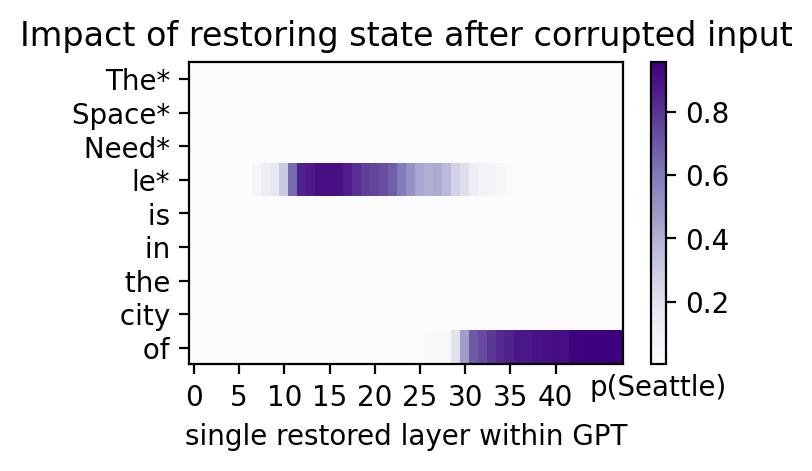

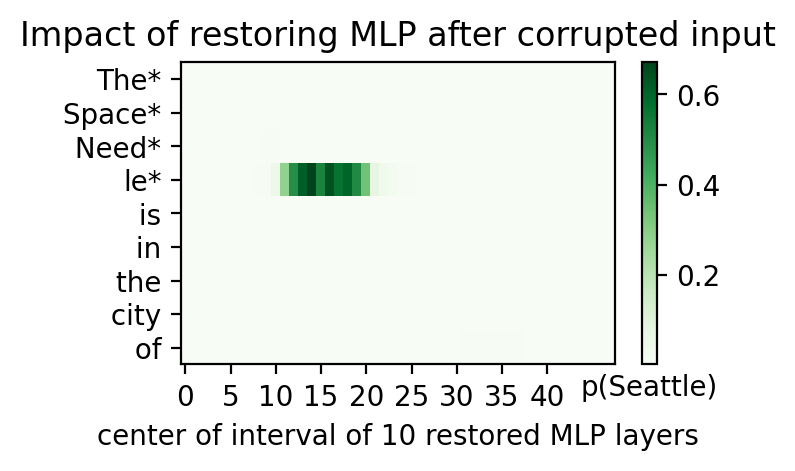

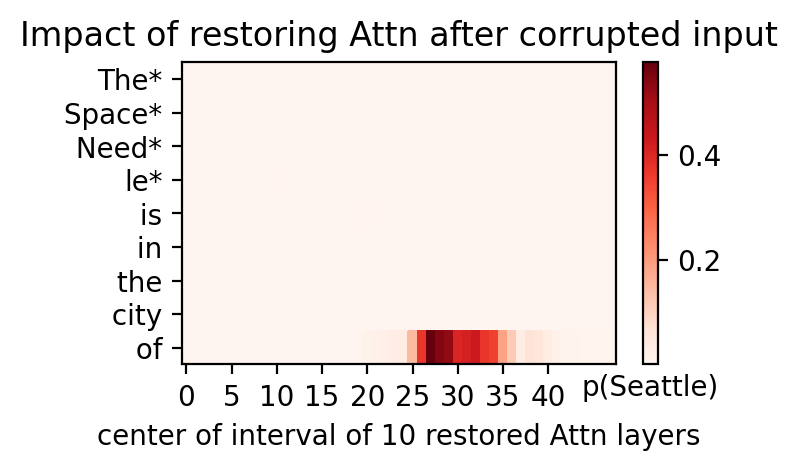

In [11]:
plot_all_flow(mt, "The Space Needle is in the city of", noise=noise_level)

Here we trace a few more factual statements from a file of test cases.

In [12]:
knowns[:5]

[{'known_id': 0,
  'subject': 'Vinson Massif',
  'attribute': 'Antarctica',
  'template': '{} is located in the continent',
  'prediction': ' of Antarctica. It is the largest of the three',
  'prompt': 'Vinson Massif is located in the continent of',
  'relation_id': 'P30'},
 {'known_id': 1,
  'subject': 'Beats Music',
  'attribute': 'Apple',
  'template': '{} is owned by',
  'prediction': ' Apple, which is also the owner of Beats Electronics',
  'prompt': 'Beats Music is owned by',
  'relation_id': 'P127'},
 {'known_id': 2,
  'subject': 'Audible.com',
  'attribute': 'Amazon',
  'template': '{} is owned by',
  'prediction': ' Amazon.com, Inc. or its affiliates.',
  'prompt': 'Audible.com is owned by',
  'relation_id': 'P127'},
 {'known_id': 3,
  'subject': 'The Big Bang Theory',
  'attribute': 'CBS',
  'template': '{} premieres on',
  'prediction': ' CBS on September 22.<|endoftext|>',
  'prompt': 'The Big Bang Theory premieres on',
  'relation_id': 'P449'},
 {'known_id': 4,
  'subject'

In [ ]:
for knowledge in knowns[:5]:
    plot_all_flow(mt, knowledge["prompt"], knowledge["subject"], noise=noise_level)

## Checking T5

In [44]:
from transformers import AutoModel

from experiments import causal_trace_t5 as ctt5

In [15]:
t5_name = "t5-base"

t5_model = AutoModel.from_pretrained(t5_name)

In [16]:
t5_model

T5Model(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dropout(p=0.1, inplac

In [25]:
[n for n, m in mt.model.named_modules()]

['',
 'transformer',
 'transformer.wte',
 'transformer.wpe',
 'transformer.drop',
 'transformer.h',
 'transformer.h.0',
 'transformer.h.0.ln_1',
 'transformer.h.0.attn',
 'transformer.h.0.attn.c_attn',
 'transformer.h.0.attn.c_proj',
 'transformer.h.0.attn.attn_dropout',
 'transformer.h.0.attn.resid_dropout',
 'transformer.h.0.ln_2',
 'transformer.h.0.mlp',
 'transformer.h.0.mlp.c_fc',
 'transformer.h.0.mlp.c_proj',
 'transformer.h.0.mlp.dropout',
 'transformer.h.1',
 'transformer.h.1.ln_1',
 'transformer.h.1.attn',
 'transformer.h.1.attn.c_attn',
 'transformer.h.1.attn.c_proj',
 'transformer.h.1.attn.attn_dropout',
 'transformer.h.1.attn.resid_dropout',
 'transformer.h.1.ln_2',
 'transformer.h.1.mlp',
 'transformer.h.1.mlp.c_fc',
 'transformer.h.1.mlp.c_proj',
 'transformer.h.1.mlp.dropout',
 'transformer.h.2',
 'transformer.h.2.ln_1',
 'transformer.h.2.attn',
 'transformer.h.2.attn.c_attn',
 'transformer.h.2.attn.c_proj',
 'transformer.h.2.attn.attn_dropout',
 'transformer.h.2.attn.r

In [22]:
[n for n, m in t5_model.named_modules()]

['',
 'shared',
 'encoder',
 'encoder.block',
 'encoder.block.0',
 'encoder.block.0.layer',
 'encoder.block.0.layer.0',
 'encoder.block.0.layer.0.SelfAttention',
 'encoder.block.0.layer.0.SelfAttention.q',
 'encoder.block.0.layer.0.SelfAttention.k',
 'encoder.block.0.layer.0.SelfAttention.v',
 'encoder.block.0.layer.0.SelfAttention.o',
 'encoder.block.0.layer.0.SelfAttention.relative_attention_bias',
 'encoder.block.0.layer.0.layer_norm',
 'encoder.block.0.layer.0.dropout',
 'encoder.block.0.layer.1',
 'encoder.block.0.layer.1.DenseReluDense',
 'encoder.block.0.layer.1.DenseReluDense.wi',
 'encoder.block.0.layer.1.DenseReluDense.wo',
 'encoder.block.0.layer.1.DenseReluDense.dropout',
 'encoder.block.0.layer.1.layer_norm',
 'encoder.block.0.layer.1.dropout',
 'encoder.block.1',
 'encoder.block.1.layer',
 'encoder.block.1.layer.0',
 'encoder.block.1.layer.0.SelfAttention',
 'encoder.block.1.layer.0.SelfAttention.q',
 'encoder.block.1.layer.0.SelfAttention.k',
 'encoder.block.1.layer.0.Se

In [26]:
t5_model.shared == t5_model.encoder.embed_tokens == t5_model.decoder.embed_tokens

True

In [122]:
model_name = "t5-base"
mt = ctt5.ModelAndTokenizer_T5(
    model_name,
    low_cpu_mem_usage=IS_COLAB,
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)

In [123]:
res = ctt5.predict_token_t5(
    mt,
    enc_sentences=["translate English to German: My name is Wolfgang and I live in Berlin."],
    dec_prompts=["Mein Name ist"],
    return_p=True,
)

In [124]:
res

(['Wolfgang'], tensor([0.9922], device='cuda:0'))

In [155]:
inp = ctt5.make_inputs_t5(
    mt.tokenizer,
    enc_sentences=["Translate to German: My name is Wolfgang and I live in Berlin"],
    dec_prompts=["Mein Name ist Wolfgang"],
    device="cuda:0",
)

In [156]:
inp

{'input_ids': tensor([[30355,    15,    12,  2968,    10,   499,   564,    19, 26513,    11,
             27,   619,    16,  4308,     1]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0'),
 'decoder_input_ids': tensor([[    0, 16232,  5570,   229, 26513]], device='cuda:0'),
 'decoder_attention_mask': tensor([[1, 1, 1, 1, 1]], device='cuda:0')}

In [157]:
mt.tokenizer.decode(inp['decoder_input_ids'][0])

'<pad> Mein Name ist Wolfgang'

In [158]:
out = mt.model(**inp)

In [159]:
out["logits"].size()

torch.Size([1, 5, 32128])

In [160]:
logits = out["logits"][0, -1].detach().cpu().numpy()
logits.shape

(32128,)

In [161]:
top_5 = sorted(list(enumerate(logits)), key=lambda p: -p[1])[:5]
top_5

[(64, -2.0804775),
 (6, -4.0525026),
 (11, -5.717272),
 (5, -5.8535347),
 (3, -7.126668)]

In [162]:
[mt.tokenizer.decode([p[0]]) for p in top_5]

['und', ',', 'and', '.', '']

### T5 analysis

In [163]:
result = ctt5.calculate_hidden_flow_t5(
    mt,
    enc_sentence="Translate to German: My name is Wolfgang and I live in Berlin",
    dec_prompt="Mein Name ist Wolfgang",
    subject="and",
)

trace_important_states_t5.encoder:   0%|          | 0/180 [00:00<?, ?it/s]

trace_important_states_t5.decoder:   0%|          | 0/60 [00:00<?, ?it/s]

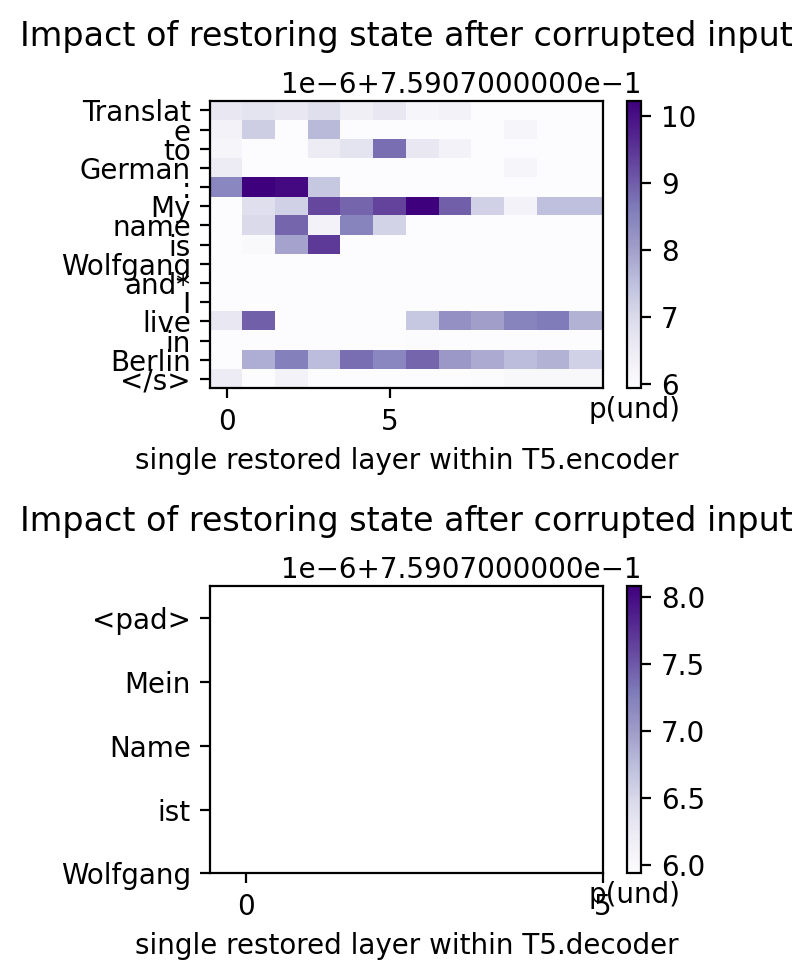

In [165]:
ctt5.plot_trace_heatmap_t5(result)

In [134]:
# named_modules remove_duplicate
set([k for k,v in mt.model.named_modules(remove_duplicate=False)]) - set([k for k,v in mt.model.named_modules(remove_duplicate=True)])

{'decoder.embed_tokens', 'encoder.embed_tokens'}

In [ ]:
# named_parameters: `remove_duplicate` not available (don't know how to include dup here...)
([k for k,v in mt.model.named_parameters()])

## USKG

In [7]:
from transformers import (
    HfArgumentParser,
    set_seed,
    AutoTokenizer
)

# from uskg.models.unified.prefixtuning import Model
from uskg.models.unified import finetune, prefixtuning
from uskg.utils.configue import Configure
from uskg.utils.training_arguments import WrappedSeq2SeqTrainingArguments
from uskg.seq2seq_construction import spider as s2s_spider
from uskg.third_party.spider.preprocess.get_tables import dump_db_json_schema
from tqdm.auto import tqdm

from experiments import causal_trace_uskg as ctu

In [8]:
mt_uskg = ctu.ModelAndTokenizer_USKG('t5-large-prefix')

Using tokenizer: t5-large
prefix-tuning sequence length is 10.


In [9]:
list(mt_uskg.task_args.seq2seq)

[('constructor', 'seq2seq_construction.spider'),
 ('schema_serialization_with_db_content', True),
 ('target_with_db_id', False)]

In [10]:
mt_uskg.model.pretrain_model.encoder.embed_tokens is mt_uskg.model.pretrain_model.shared, \
mt_uskg.model.pretrain_model.decoder.embed_tokens is mt_uskg.model.pretrain_model.shared

(True, False)

In [11]:
# [k for k,v in mt_uskg.model.named_parameters()]

In [12]:
inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    enc_sentences=["Translate to German: My name is Wolfgang and I live in Berlin"],
    dec_prompts=["Mein Name ist Wolfgang"],
    device="cuda:0"
)

In [13]:
out = ctu.run_model_forward_uskg(mt_uskg.model, **inp)

In [14]:
out.keys(), out['logits'].size()

(odict_keys(['logits', 'past_key_values', 'encoder_last_hidden_state']),
 torch.Size([1, 5, 32102]))

In [15]:
logits = out["logits"][0, -1].detach().cpu().numpy()
logits.shape

(32102,)

In [16]:
top_5 = sorted(list(enumerate(logits)), key=lambda p: -p[1])[:5]
top_5

[(11, -1.8642352),
 (6, -9.727753),
 (5, -10.966707),
 (27, -11.037394),
 (213, -12.864212)]

In [17]:
[mt_uskg.tokenizer.decode([p[0]]) for p in top_5]

['and', ',', '.', 'I', 'where']

### USKG analysis - toy example

In [ ]:
result = ctu.calculate_hidden_flow_uskg(
    mt_uskg,
    enc_sentence="Translate to German: My name is Wolfgang and I live in Berlin",
    dec_prompt="Mein Name",
    expect="ist Wolfgang"
#     subject="and",
)

In [ ]:
ctu.plot_trace_heatmap_t5(result)

### Load spider dataset

In [19]:
spider_dev_path = '/home/yshao/Projects/SDR-analysis/data/spider/dev+ratsql_graph.json'
spider_db_dir = '/home/yshao/Projects/language/language/xsp/data/spider/database'

# with open(spider_dev_path, 'r') as f:
#     raw_spider_dev = json.load(f)
# len(raw_spider_dev)

In [20]:
# ## adapted from uskg/tasks/spider.py

# SCHEMA_CACHE = dict()

# def load_raw_dataset(data_filepath, db_path, schema_cache=None):
#     with open(data_filepath, encoding="utf-8") as f:
#         spider = json.load(f)

#     out_dataset = []
#     for idx, sample in enumerate(spider):
#         db_id = sample["db_id"]
#         if db_id not in schema_cache:
#             schema_cache[db_id] = dump_db_json_schema(
#                 db_path + "/" + db_id + "/" + db_id + ".sqlite", db_id
#             )
#         schema = schema_cache[db_id]
#         out_dataset.append({
#             "query": sample["query"],
#             "question": sample["question"],
#             "db_id": db_id,
#             "db_path": db_path,
#             "db_table_names": schema["table_names_original"],
# #             "db_column_names": [
# #                 {"table_id": table_id, "column_name": column_name}
# #                 for table_id, column_name in schema["column_names_original"]
# #             ],
#             "db_column_names": {
#                 "table_id": [table_id for table_id, _ in schema["column_names_original"]],
#                 "column_name": [column_name for _, column_name in schema["column_names_original"]]
#             },
#             "db_column_types": schema["column_types"],
# #             "db_primary_keys": [{"column_id": column_id} for column_id in schema["primary_keys"]],
#             "db_primary_keys": {
#                 "column_id": schema["primary_keys"]
#             },
# #             "db_foreign_keys": [
# #                 {"column_id": column_id, "other_column_id": other_column_id}
# #                 for column_id, other_column_id in schema["foreign_keys"]
# #             ],
#             "db_foreign_keys": {
#                 "column_id": [column_id for column_id, _ in schema["foreign_keys"]],
#                 "other_column_id": [other_column_id for _, other_column_id in schema["foreign_keys"]]
#             },
#             "rat_sql_graph": sample["rat_sql_graph"]
#         })
#     return out_dataset

In [21]:
raw_spider_dev = ctu.load_raw_dataset(
    data_filepath = spider_dev_path,
    db_path=spider_db_dir,
#     schema_cache=SCHEMA_CACHE
)
len(raw_spider_dev)

1034

In [22]:
raw_spider_dev[0].keys()

dict_keys(['query', 'question', 'db_id', 'db_path', 'db_table_names', 'db_column_names', 'db_column_types', 'db_primary_keys', 'db_foreign_keys', 'rat_sql_graph'])

In [23]:
mt_uskg.task_args.dataset.use_cache

True

In [24]:
# _args = copy.deepcopy(mt_uskg.task_args)
# _args.dataset.use_cache = False

processed_spider_dev = s2s_spider.DevDataset(
    args=mt_uskg.task_args,
    raw_datasets=raw_spider_dev,
    cache_root='../cache')

In [25]:
processed_spider_dev[4]['struct_in']

'| concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country ( France ) , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id'

In [30]:
# _occ_punct = set()

for _id in range(len(processed_spider_dev)):
    ex = processed_spider_dev[_id]
#     _occ_punct.update(set(string.punctuation) & set(ex['seq_out']))
    if '_(' in ex['struct_in'] and 'official' in ex['seq_out']:
        print(_id, ex['question'])
        print(ex['struct_in'])
        print(ex['seq_out'])
        print()

In [31]:
# ''.join(_occ_punct)

#### Analysis sample 1 (ID = 0)

In [32]:
ex = processed_spider_dev[0]
ex['question'], ex['seq_out']

('How many singers do we have?', 'select count(*) from singer')

In [33]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = 'select count(*) from'

inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    enc_sentences=[enc_sentence],
    dec_prompts=[dec_prompt],
    device="cuda:0"
)

In [34]:
mt_uskg.tokenizer.decode(inp['input_ids'][0]), mt_uskg.tokenizer.decode(inp['decoder_input_ids'][0])

('How many singers do we have?; structed knowledge: | concert_singer | stadium : stadium_id, location, name, capacity, highest, lowest, average | singer : singer_id, name, country, song_name, song_release_year, age, is_male | concert : concert_id, concert_name, theme, stadium_id, year | singer_in_concert : concert_id, singer_id</s>',
 '<pad> select count(*) from')

In [35]:
out = ctu.run_model_forward_uskg(mt_uskg.model, **inp)

In [36]:
out.keys(), out['logits'].size()

(odict_keys(['logits', 'past_key_values', 'encoder_last_hidden_state']),
 torch.Size([1, 7, 32102]))

In [37]:
logits = out["logits"][0, -1].detach().cpu().numpy()
logits.shape

(32102,)

In [38]:
top_5 = sorted(list(enumerate(logits)), key=lambda p: -p[1])[:5]
top_5

[(7634, -5.629301),
 (6721, -15.1248665),
 (10159, -17.77869),
 (2377, -18.263933),
 (8782, -18.631098)]

In [39]:
[mt_uskg.tokenizer.decode([p[0]]) for p in top_5]

['singer', 'vocal', 'sing', 'artist', 'singing']

In [40]:
# e_range = ctu.find_token_range(mt_uskg.tokenizer, inp["input_ids"][0], 'singer')
# e_range

In [41]:
text_range, struct_range = ctu.find_text_struct_in_range(mt_uskg.tokenizer, inp["input_ids"][0])
text_range, struct_range

((0, 8), (15, 125))

In [42]:
tb, te = text_range
sb, se = struct_range
mt_uskg.tokenizer.decode(inp['input_ids'][0]), \
mt_uskg.tokenizer.decode(inp['input_ids'][0][tb:te]), \
mt_uskg.tokenizer.decode(inp['input_ids'][0][sb:se])

('How many singers do we have?; structed knowledge: | concert_singer | stadium : stadium_id, location, name, capacity, highest, lowest, average | singer : singer_id, name, country, song_name, song_release_year, age, is_male | concert : concert_id, concert_name, theme, stadium_id, year | singer_in_concert : concert_id, singer_id</s>',
 'How many singers do we have?',
 '| concert_singer | stadium : stadium_id, location, name, capacity, highest, lowest, average | singer : singer_id, name, country, song_name, song_release_year, age, is_male | concert : concert_id, concert_name, theme, stadium_id, year | singer_in_concert : concert_id, singer_id')

In [43]:
result = ctu.calculate_hidden_flow_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    subject='singer',
    replace=True,
)

calculate_hidden_flow_uskg(): corrupted input: *How *many *singer *s *do *we *have *? *; * *struct *e *d *knowledge *: *| *concert *_ *s *inger *| *stadium * *: *stadium *_ *i *d * *, *location * *, *name * *, *capacity * *, *highest * *, *lowest * *, *average *| *singer * *: *singer *_ *i *d * *, *name * *, *country * *, *song *_ *name * *, *song *_ *release *_ *year * *, *age * *, *is *_ *male *| *concert * *: *concert *_ *i *d * *, *concert *_ *name * *, *theme * *, *stadium *_ *i *d * *, *year *| *singer *_ *in *_ *conce *r *t * *: *concert *_ *i *d * *, *singer *_ *i *d *</s>


trace_important_states_uskg.encoder:   0%|          | 0/1512 [00:00<?, ?it/s]

trace_important_states_uskg.decoder:   0%|          | 0/84 [00:00<?, ?it/s]

In [44]:
result.keys(), result['correct_prediction']

(dict_keys(['scores', 'low_score', 'high_score', 'input_ids', 'input_tokens', 'dec_input_ids', 'dec_input_tokens', 'subject_range', 'answer', 'window', 'correct_prediction', 'kind']),
 True)

In [45]:
result['low_score']

3.2487089356436627e-06

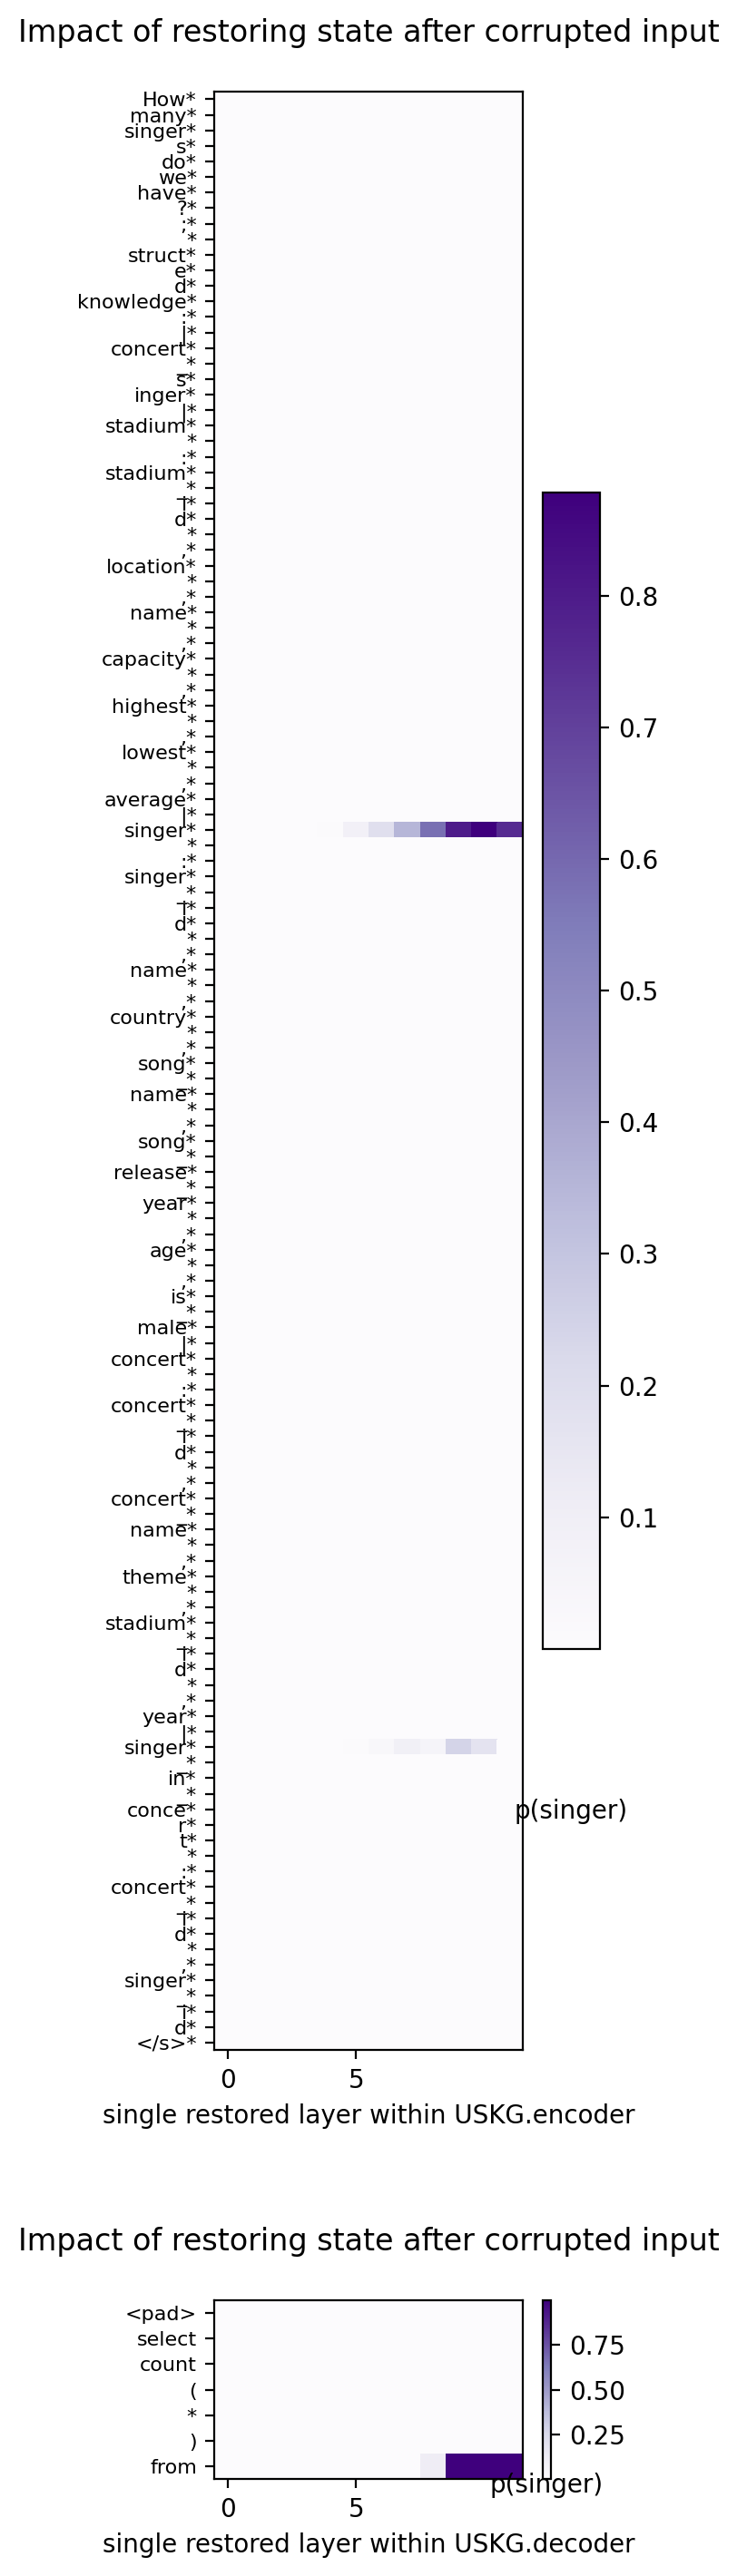

In [49]:
ctu.plot_trace_heatmap_t5(result)

#### Analysis sample 2 (ID = 9)

In [50]:
_id = 9
ex = processed_spider_dev[_id]
ex['question'], ex['seq_out']

('What are  the different countries with singers above age 20?',
 'select distinct country from singer where age > 20')

In [51]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = "select distinct country from singer where"
expect = "age"

In [52]:
struct_in

'| concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id'

In [53]:
result = ctu.calculate_hidden_flow_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    subject='singer',
    replace=True,
    expect=expect,
)

calculate_hidden_flow_uskg(): corrupted input: *What *are *the *different *countries *with *singer *s *above *age *20 *? *; * *struct *e *d *knowledge *: *| *concert *_ *s *inger *| *stadium * *: *stadium *_ *i *d * *, *location * *, *name * *, *capacity * *, *highest * *, *lowest * *, *average *| *singer * *: *singer *_ *i *d * *, *name * *, *country * *, *song *_ *name * *, *song *_ *release *_ *year * *, *age * *, *is *_ *male *| *concert * *: *concert *_ *i *d * *, *concert *_ *name * *, *theme * *, *stadium *_ *i *d * *, *year *| *singer *_ *in *_ *conce *r *t * *: *concert *_ *i *d * *, *singer *_ *i *d *</s>


trace_important_states_uskg.encoder:   0%|          | 0/1560 [00:00<?, ?it/s]

trace_important_states_uskg.decoder:   0%|          | 0/84 [00:00<?, ?it/s]

In [54]:
result.keys(), result['correct_prediction'], result['high_score'], result['low_score']

(dict_keys(['scores', 'low_score', 'high_score', 'input_ids', 'input_tokens', 'dec_input_ids', 'dec_input_tokens', 'subject_range', 'answer', 'window', 'correct_prediction', 'kind']),
 True,
 tensor(1.0000, device='cuda:0'),
 0.0005113474908284843)

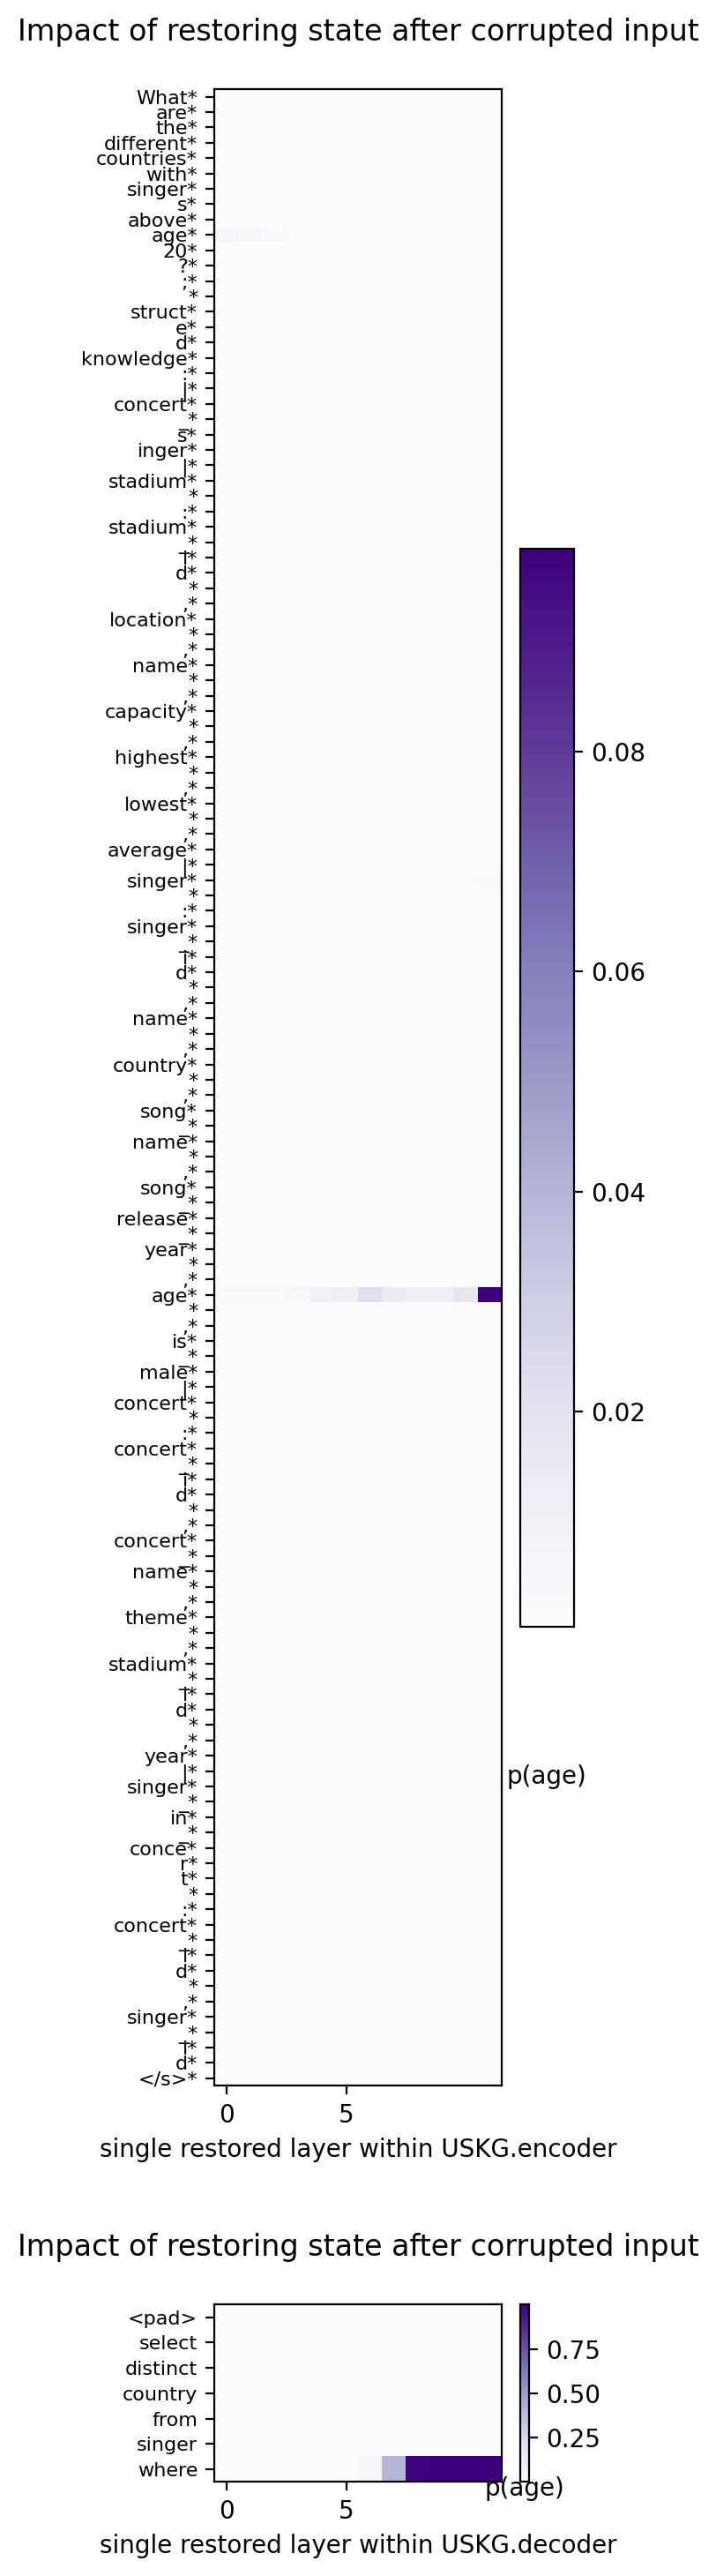

In [55]:
ctu.plot_trace_heatmap_t5(result)

#### Analysis sample 3 (ID = 97)

In [56]:
_id = 97
ex = processed_spider_dev[_id]
ex['question'], ex['seq_out']

('Find the model of the car whose weight is below the average weight.',
 'select t1.model from car_names as t1 join cars_data as t2 on t1.makeid = t2.id where t2.weight < (select avg(weight) from cars_data)')

In [57]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = "select t1.model from car_names as t1 join cars_"
expect = "data"

In [58]:
struct_in

'| car_1 | continents : contid , continent | countries : countryid , countryname , continent | car_makers : id , maker , fullname , country | model_list : modelid , maker , model | car_names : makeid , model , make | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year'

In [59]:
# text_in = ex['text_in']
# struct_in = ex['struct_in']

# enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
# dec_prompt = "select t1.model from car_names as t1 join cars_"
# expect = "data"

inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    enc_sentences=[enc_sentence],
    dec_prompts=[dec_prompt],
    device="cuda:0"
)
out = ctu.run_model_forward_uskg(mt_uskg.model, **inp)
logits = out["logits"][0, -1].detach().cpu().numpy()

top_5 = sorted(list(enumerate(logits)), key=lambda p: -p[1])[:5]

[(mt_uskg.tokenizer.decode([p[0]]), p[1]) for p in top_5]


[('data', -10.943039),
 ('stat', -21.073414),
 ('daten', -22.921432),
 ('re', -23.442766),
 ('performance', -23.719862)]

In [60]:
result = ctu.calculate_hidden_flow_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    subject=None,
    replace=True,
    expect=expect,
)

calculate_hidden_flow_uskg(): corrupted input: *Find *the *model *of *the *car * *whose *weight *is *below *the *average *weight *. *; * *struct *e *d *knowledge *: *| *car *_ *1 *| *continent *s * *: *cont *i *d * *, *continent *| *countries * *: *country *i *d * *, *country *name * *, *continent *| *car *_ *makers * *: * *i *d * *, *maker * *, *full *name * *, *country *| *model *_ *list * *: *model *i *d * *, *maker * *, *model *| *car *_ *name *s * *: *make *i *d * *, *model * *, *make *| *cars *_ *data * *: * *i *d * *, * *mp *g * *, * *cylinder *s * *, * *e *disp *l * *, *horsepower * *, *weight * *, *accelerate * *, *year *</s>


trace_important_states_uskg.encoder:   0%|          | 0/1668 [00:00<?, ?it/s]

trace_important_states_uskg.decoder:   0%|          | 0/216 [00:00<?, ?it/s]

In [61]:
result.keys(), result['correct_prediction'], result['high_score'], result['low_score']

(dict_keys(['scores', 'low_score', 'high_score', 'input_ids', 'input_tokens', 'dec_input_ids', 'dec_input_tokens', 'subject_range', 'answer', 'window', 'correct_prediction', 'kind']),
 True,
 tensor(0.9999, device='cuda:0'),
 0.0008115010568872094)

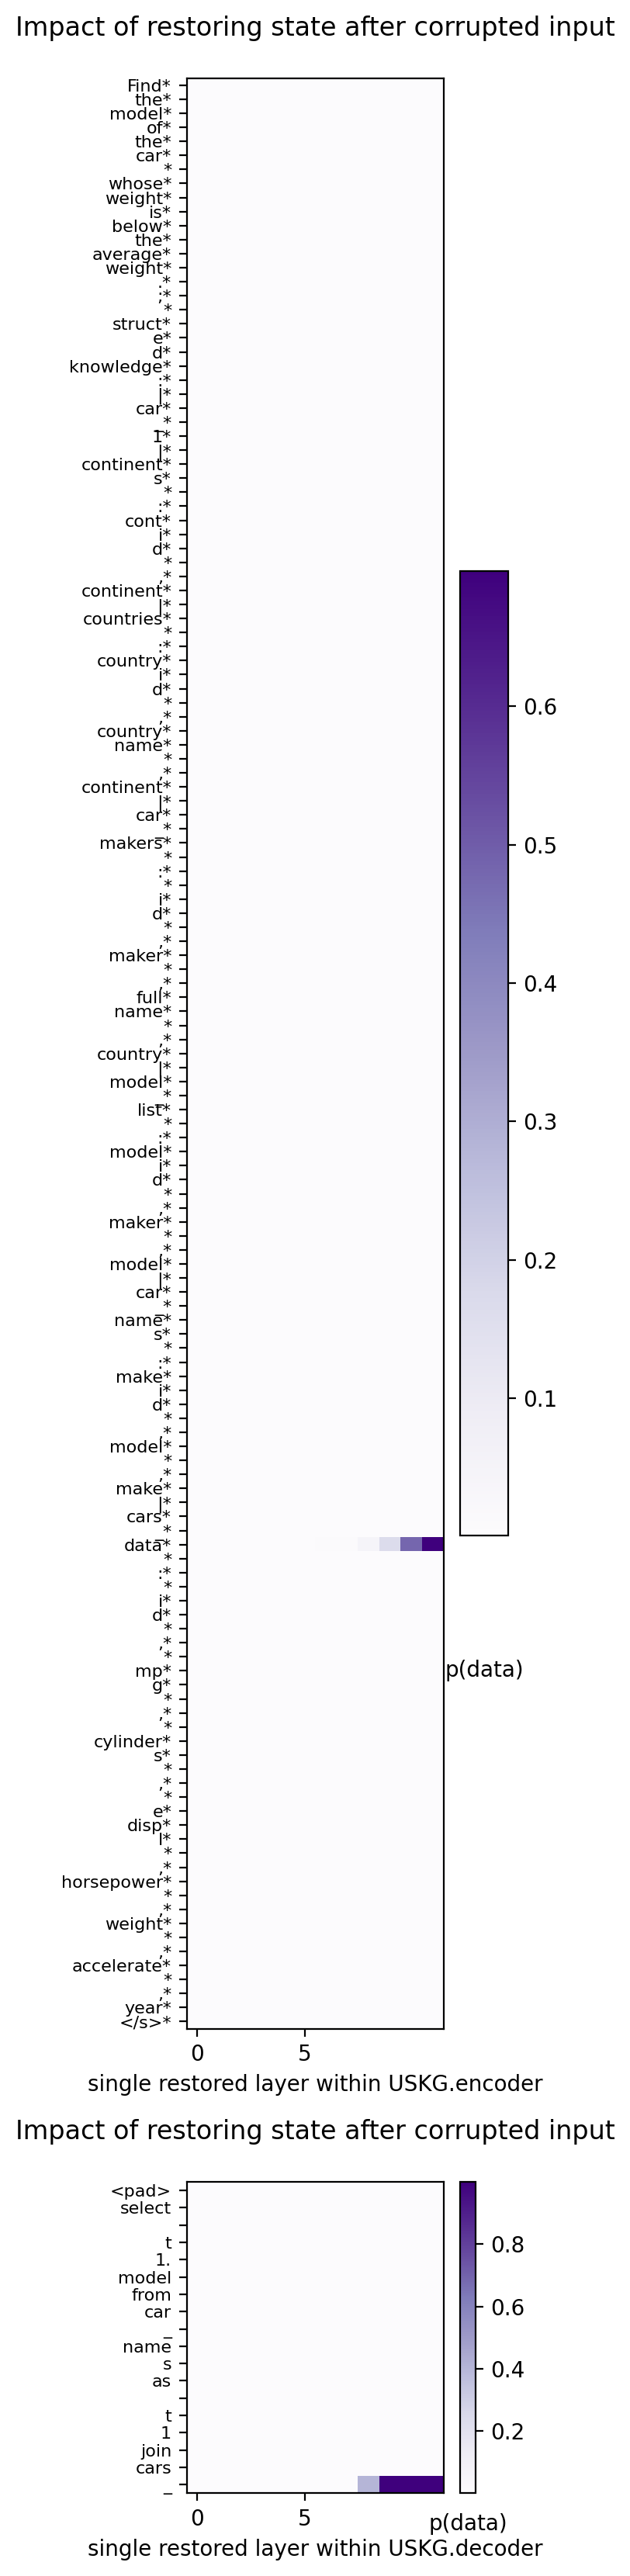

In [62]:
ctu.plot_trace_heatmap_t5(result)

In [63]:
# Another position

In [69]:
enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = "select t1.model from car_names"
expect = "as"  # 't1' -> '_', 't', '1'

In [70]:
result = ctu.calculate_hidden_flow_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    subject=None,
    replace=True,
    expect=expect,
)

calculate_hidden_flow_uskg(): corrupted input: *Find *the *model *of *the *car * *whose *weight *is *below *the *average *weight *. *; * *struct *e *d *knowledge *: *| *car *_ *1 *| *continent *s * *: *cont *i *d * *, *continent *| *countries * *: *country *i *d * *, *country *name * *, *continent *| *car *_ *makers * *: * *i *d * *, *maker * *, *full *name * *, *country *| *model *_ *list * *: *model *i *d * *, *maker * *, *model *| *car *_ *name *s * *: *make *i *d * *, *model * *, *make *| *cars *_ *data * *: * *i *d * *, * *mp *g * *, * *cylinder *s * *, * *e *disp *l * *, *horsepower * *, *weight * *, *accelerate * *, *year *</s>


trace_important_states_uskg.encoder:   0%|          | 0/1668 [00:00<?, ?it/s]

trace_important_states_uskg.decoder:   0%|          | 0/132 [00:00<?, ?it/s]

In [71]:
result.keys(), result['correct_prediction'], result['high_score'], result['low_score']

(dict_keys(['scores', 'low_score', 'high_score', 'input_ids', 'input_tokens', 'dec_input_ids', 'dec_input_tokens', 'subject_range', 'answer', 'window', 'correct_prediction', 'kind']),
 True,
 tensor(1.0000, device='cuda:0'),
 0.9942196011543274)

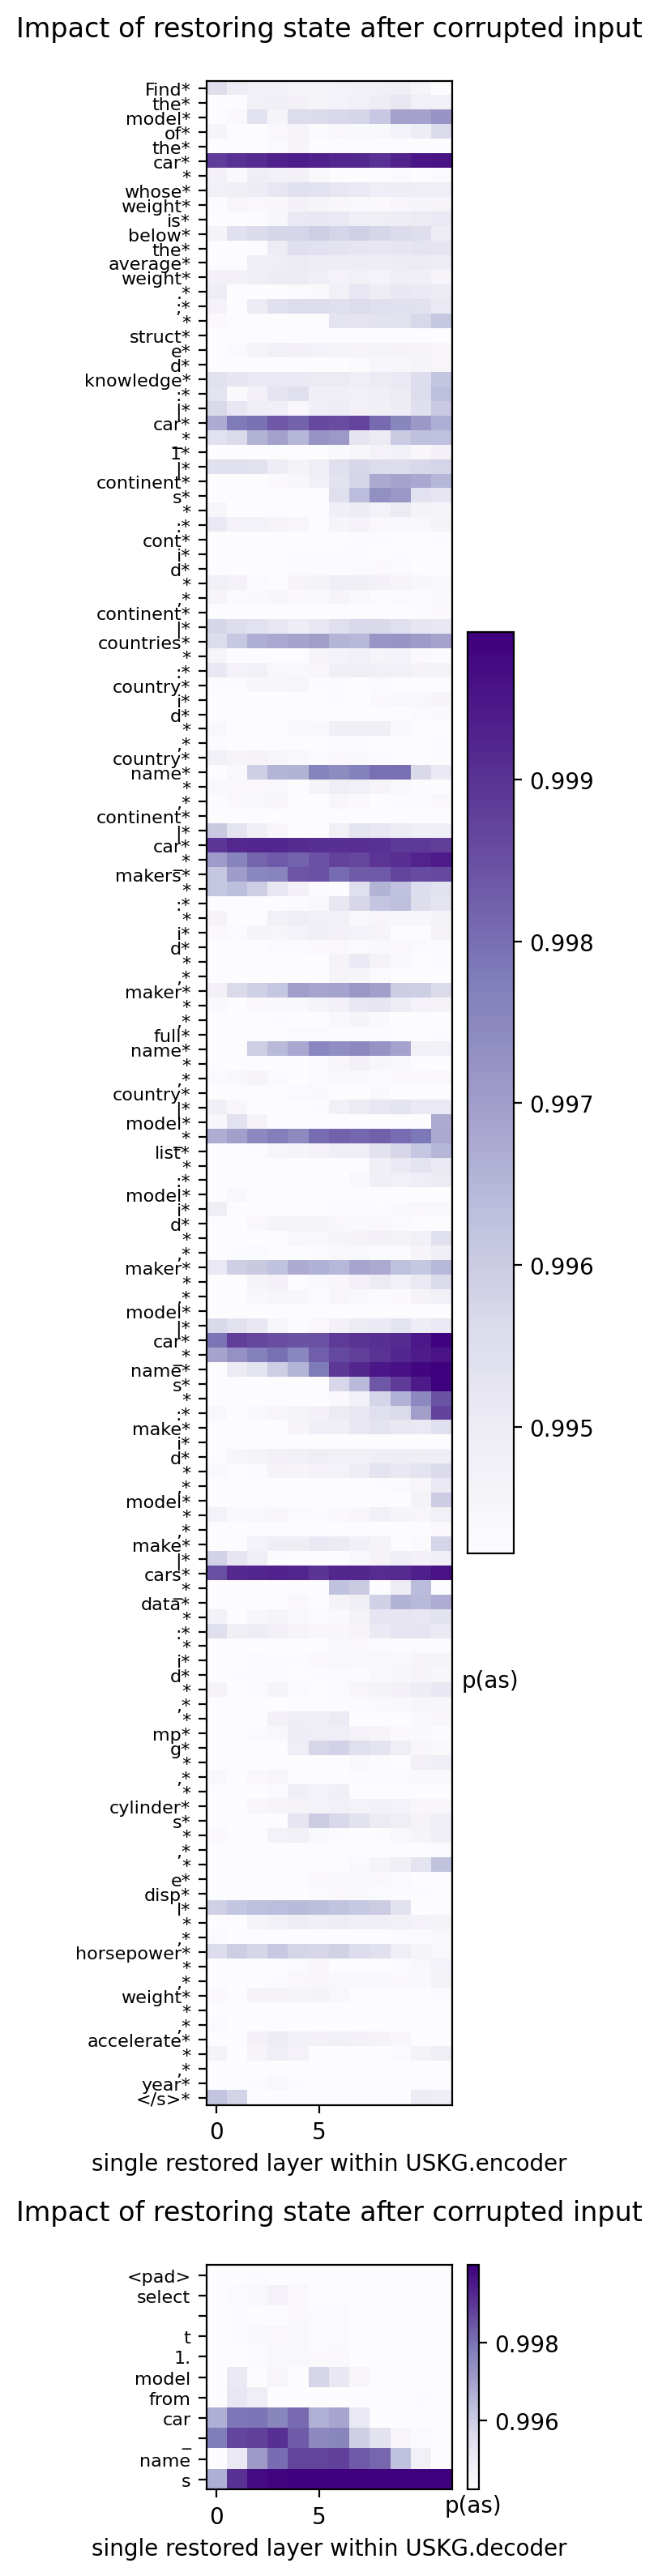

In [72]:
ctu.plot_trace_heatmap_t5(result)

### Study the influence of corrupting a token

In [29]:
_id = 97
ex = processed_spider_dev[_id]
ex['question'], ex['seq_out']

('Find the model of the car whose weight is below the average weight.',
 'select t1.model from car_names as t1 join cars_data as t2 on t1.makeid = t2.id where t2.weight < (select avg(weight) from cars_data)')

In [30]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"

# dec_prompt = 'select count(*) from'
# expect = 'singer'
# dec_prompt = 'select distinct country from singer where'
# expect = 'age'
dec_prompt = 'select t1.model from'
expect = 'car_names'

In [31]:
ans_toks = decode_tokens(mt_uskg.tokenizer, mt_uskg.tokenizer.encode(expect, add_special_tokens=False))
ans_toks

['car', '_', 'name', 's']

In [42]:
result = ctu.token_corruption_influence_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    expect=expect,
    replace=True,
)

  0%|          | 0/138 [00:00<?, ?it/s]

In [116]:
# # ID = 0

# l = []
# for i, d in enumerate(result):
#     if d['corrpt_drop'] > 0.1:
#         l.append(f'{i}*\t{d["corrpt_token"]}\t{d["corrpt_drop"]}')
#     else:
#         l.append(f'{i}\t{d["corrpt_token"]}\t{d["corrpt_drop"]}')
# print('\n'.join(l))

0	How	-5.125999450683594e-06
1	many	2.2232532501220703e-05
2*	singer	0.9999071359067503
3	s	6.67572021484375e-06
4	do	6.318092346191406e-06
5	we	4.684925079345703e-05
6	have	9.715557098388672e-06
7	?	1.4901161193847656e-05
8	;	9.179115295410156e-06
9		7.927417755126953e-06
10	struct	5.424022674560547e-06
11	e	2.086162567138672e-06
12	d	2.3245811462402344e-06
13	knowledge	-5.364418029785156e-07
14	:	1.0728836059570312e-06
15	|	4.112720489501953e-06
16	concert	-2.2232532501220703e-05
17	_	3.635883331298828e-06
18	s	1.2993812561035156e-05
19	inger	1.2040138244628906e-05
20	|	7.748603820800781e-06
21	stadium	1.7881393432617188e-07
22		-1.4901161193847656e-06
23	:	5.185604095458984e-06
24	stadium	-3.6954879760742188e-06
25	_	1.6093254089355469e-06
26	i	-1.7285346984863281e-06
27	d	-1.1324882507324219e-06
28		-5.364418029785156e-07
29	,	3.993511199951172e-06
30	location	9.238719940185547e-06
31		7.748603820800781e-07
32	,	6.377696990966797e-06
33	name	7.748603820800781e-07
34		-5.36441802978

In [138]:
# # ID = 9

# l = []
# for i, d in enumerate(result):
#     if d['corrpt_drop'] > 0.1:
#         l.append(f'{i}*\t{d["corrpt_token"]}\t{d["corrpt_drop"]}')
#     else:
#         l.append(f'{i}\t{d["corrpt_token"]}\t{d["corrpt_drop"]}')
# print('\n'.join(l))

0	What	-2.384185791015625e-07
1	are	-1.7881393432617188e-07
2	the	5.960464477539063e-08
3	different	7.748603820800781e-07
4	countries	1.9788742065429688e-05
5	with	-5.960464477539063e-08
6	singer	0.014161169528961182
7	s	-3.5762786865234375e-07
8	above	1.3709068298339844e-06
9	age	1.627206802368164e-05
10	20	-5.960464477539063e-08
11	?	-5.960464477539063e-08
12	;	7.748603820800781e-07
13		-1.7881393432617188e-07
14	struct	5.960464477539063e-08
15	e	-5.960464477539063e-08
16	d	-5.960464477539063e-08
17	knowledge	-1.7881393432617188e-07
18	:	-1.7881393432617188e-07
19	|	-1.7881393432617188e-07
20	concert	-5.960464477539063e-08
21	_	5.960464477539063e-08
22	s	-5.960464477539063e-08
23	inger	-5.960464477539063e-08
24	|	2.980232238769531e-07
25	stadium	-5.960464477539063e-08
26		-5.960464477539063e-08
27	:	2.980232238769531e-07
28	stadium	-5.960464477539063e-08
29	_	-5.960464477539063e-08
30	i	-1.7881393432617188e-07
31	d	-5.960464477539063e-08
32		-5.960464477539063e-08
33	,	2.384185791015

In [43]:
# ID = 97

l = []
for i, d in enumerate(result):
    if d['corrpt_drop'] > 0.1:
        l.append(f'*{i}*\t{d["corrpt_token"]}\t{d["corrpt_drop"]}')
    else:
        l.append(f'{i}\t{d["corrpt_token"]}\t{d["corrpt_drop"]}')
print('\n'.join(l))

0	Find	0.05351823568344116
*1*	the	0.371318981051445
*2*	model	0.3018887937068939
*3*	of	0.2037137746810913
*4*	the	0.13106441497802734
*5*	car	0.5552929053083062
*6*		0.11733737587928772
7	whose	-0.042909860610961914
8	weight	-0.41375404596328735
9	is	-0.11253219842910767
10	below	0.03791862726211548
11	the	-0.0040700435638427734
12	average	0.09445622563362122
13	weight	-0.3462866544723511
14	.	-0.11110246181488037
15	;	0.010776817798614502
16		-0.128959059715271
17	struct	-0.11200851202011108
18	e	-0.02005743980407715
19	d	-0.07771629095077515
20	knowledge	-0.013707339763641357
21	:	-0.014791369438171387
22	|	0.017944157123565674
23	car	-0.05754750967025757
24	_	0.09156212210655212
25	1	0.06080251932144165
26	|	0.016861021518707275
27	continent	-0.03279966115951538
28	s	0.04899948835372925
29		0.051177978515625
30	:	0.031367361545562744
31	cont	0.04724991321563721
32	i	0.02842181921005249
33	d	0.01387101411819458
34		0.023250162601470947
35	,	0.003944694995880127
36	continent	-0.0087

In [40]:
# inp = ctu.make_inputs_t5(mt_uskg.tokenizer, [text_in] * 11, [dec_prompt] * 11)
inp = ctu.make_inputs_t5(mt_uskg.tokenizer, [enc_sentence] * 11, [dec_prompt] * 11, answer=expect, device='cpu')
# answer_t, base_score = [d[0] for d in ctu.predict_from_input_uskg(mt_uskg.model, inp)]
# base_score = base_score.item()
# [answer] = ctu.decode_tokens(mt_uskg.tokenizer, [answer_t])
answer_len = 1
if expect is not None:
    answer_len = len(mt_uskg.tokenizer.tokenize(expect))
with torch.no_grad():
    answers_t, base_score = [d[0] for d in ctu.predict_from_input_uskg_multi_token(mt_uskg.model, inp, pred_len=answer_len)]
# base_score = base_score.min().item()
# [answer] = decode_tokens(mt.tokenizer, [answer_t])
answer = ctu.decode_sentences(mt_uskg.tokenizer, answers_t)

expect, answers_t, answer, base_score

('car_names',
 tensor([ 443,  834, 4350,    7]),
 'car_names',
 tensor([0.5643, 1.0000, 0.9996, 1.0000]))

In [ ]:
# e_range = (129, 132)
# e_range = [8, 13, 131]
e_range = list(range(7, 14))

r = ctu.trace_with_patch_uskg(
    mt_uskg.model,
    inp=inp,
    states_to_patch=[], 
    answers_t=answer_t, 
    tokens_to_mix=e_range,
    tokens_to_mix_individual_indices=True,
    replace=True,
)

r

### Analyse multi-tokens

#### Sample 4 (ID = 97)
- FROM table
- t5-base-p: wrong prediction
- t5-large-p: correct (but p is only ~0.56)

In [23]:
_id = 97
ex = processed_spider_dev[_id]
ex['question'], ex['struct_in'], ex['seq_out']

('Find the model of the car whose weight is below the average weight.',
 '| car_1 | continents : contid , continent | countries : countryid , countryname , continent | car_makers : id , maker , fullname , country | model_list : modelid , maker , model | car_names : makeid , model , make | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year',
 'select t1.model from car_names as t1 join cars_data as t2 on t1.makeid = t2.id where t2.weight < (select avg(weight) from cars_data)')

In [24]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = "select t1.model from"
expect = "car_names"

ans_toks = decode_tokens(mt_uskg.tokenizer, mt_uskg.tokenizer.encode(expect, add_special_tokens=False))
ans_toks

['car', '_', 'name', 's']

In [25]:
inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    enc_sentences=[enc_sentence],
    dec_prompts=[dec_prompt],
    answer=expect,
    device="cuda:0"
)
out = ctu.run_model_forward_uskg(mt_uskg.model, **inp)
ans_logits = out["logits"][0, -len(ans_toks):].detach().cpu()
ans_probs = ans_logits.softmax(dim=-1).numpy()

ans_top_5 = []
for probs in ans_probs:
    top_5 = sorted(list(enumerate(probs)), key=lambda p: -p[1])[:5]
    ans_top_5.append(top_5)

[[(mt_uskg.tokenizer.decode([p[0]]), p[1]) for p in top_5] for top_5 in ans_top_5]

[[('car', 0.56428814),
  ('model', 0.43506715),
  ('vehicle', 0.00021862303),
  ('cars', 0.00014308267),
  ('models', 8.6197484e-05)],
 [('_', 0.9999999),
  ('-', 7.3583514e-08),
  ("'", 4.1157877e-09),
  ('/', 1.4668213e-09),
  ('\xad', 8.863828e-10)],
 [('name', 0.9996331),
  ('list', 0.00026160118),
  ('naming', 3.392447e-05),
  ('namen', 1.0954519e-05),
  ('Name', 8.198361e-06)],
 [('s', 0.9999963),
  ('as', 3.6612994e-06),
  ('and', 1.3562294e-08),
  ('_', 1.0642934e-08),
  ('', 3.6112402e-09)]]

In [ ]:
result = ctu.calculate_hidden_flow_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    subject=None,
    replace=True,
    expect=expect,
)

#### Sample 5 (ID = 97)
- JOIN table
- t5-base-p: wrong prediction
- t5-large-p: also wrong prediction

In [26]:
_id = 97
ex = processed_spider_dev[_id]
ex['question'], ex['struct_in'], ex['seq_out']

('Find the model of the car whose weight is below the average weight.',
 '| car_1 | continents : contid , continent | countries : countryid , countryname , continent | car_makers : id , maker , fullname , country | model_list : modelid , maker , model | car_names : makeid , model , make | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year',
 'select t1.model from car_names as t1 join cars_data as t2 on t1.makeid = t2.id where t2.weight < (select avg(weight) from cars_data)')

In [27]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = "select t1.model from car_names as t1 join"
expect = "cars_data"

ans_toks = decode_tokens(mt_uskg.tokenizer, mt_uskg.tokenizer.encode(expect, add_special_tokens=False))
ans_toks

['cars', '_', 'data']

In [28]:
inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    enc_sentences=[enc_sentence],
    dec_prompts=[dec_prompt],
    answer=expect,
    device="cuda:0"
)
out = ctu.run_model_forward_uskg(mt_uskg.model, **inp)
ans_logits = out["logits"][0, -len(ans_toks):].detach().cpu()
ans_probs = ans_logits.softmax(dim=-1).numpy()

ans_top_5 = []
for probs in ans_probs:
    top_5 = sorted(list(enumerate(probs)), key=lambda p: -p[1])[:5]
    ans_top_5.append(top_5)

[[(mt_uskg.tokenizer.decode([p[0]]), p[1]) for p in top_5] for top_5 in ans_top_5]

[[('model', 0.9760669),
  ('car', 0.016085088),
  ('cars', 0.0039663976),
  ('models', 0.0038412896),
  ('', 9.609355e-06)],
 [('_', 1.0),
  ('-', 2.7060212e-08),
  ("'", 1.5179106e-09),
  ('\xad', 6.841498e-10),
  ('data', 6.186581e-10)],
 [('data', 0.99999964),
  ('Data', 2.567518e-07),
  ('DATA', 4.1680394e-08),
  ('video', 1.4779907e-08),
  ('daten', 5.5116405e-09)]]

#### Sample 6 (ID = 666)
- SELECT column (exact match with \_ )

In [73]:
_id = 666
ex = processed_spider_dev[_id]
ex['db_id'], ex['question'], ex['struct_in'], ex['seq_out']

('poker_player',
 'Return the birth date of the poker player with the lowest earnings.',
 '| poker_player | poker_player : poker_player_id , people_id , final_table_made , best_finish , money_rank , earnings | people : people_id , nationality , name , birth_date , height',
 'select t1.birth_date from people as t1 join poker_player as t2 on t1.people_id = t2.people_id order by t2.earnings asc limit 1')

In [45]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = "select t1."
expect = "birth_date"

ans_toks = decode_tokens(mt_uskg.tokenizer, mt_uskg.tokenizer.encode(expect, add_special_tokens=False))
ans_toks

['birth', '_', 'date']

In [52]:
inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    enc_sentences=[enc_sentence]*11,
    dec_prompts=[dec_prompt]*11,
    answer=expect,
)
out = ctu.run_model_forward_uskg(mt_uskg.model, **inp)
ans_logits = out["logits"][0, -len(ans_toks):].detach().cpu()
ans_probs = ans_logits.softmax(dim=-1).numpy()

ans_top_5 = []
for probs in ans_probs:
    top_5 = sorted(list(enumerate(probs)), key=lambda p: -p[1])[:5]
    ans_top_5.append(top_5)

[[(mt_uskg.tokenizer.decode([p[0]]), p[1]) for p in top_5] for top_5 in ans_top_5]

[[('birth', 0.9999958),
  ('born', 3.516807e-06),
  ('b', 5.719771e-07),
  ('bab', 4.4713634e-08),
  ('life', 2.745312e-08)],
 [('_', 0.9999999),
  ('-', 1.3111651e-07),
  ('\xad', 1.8326639e-10),
  ("'", 3.599415e-11),
  ('date', 2.546532e-11)],
 [('date', 0.99999607),
  ('day', 3.6722647e-06),
  ('dated', 7.673061e-08),
  ('name', 4.8584365e-08),
  ('year', 4.305469e-08)]]

In [47]:
# corruption analysis
result = ctu.token_corruption_influence_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    expect=expect,
    replace=True,
)

  0%|          | 0/85 [00:00<?, ?it/s]

In [49]:
# ID = 666

l = []
for i, d in enumerate(result):
    if d['corrpt_drop'] > 0.1:
        l.append(f'*{i}*\t{d["corrpt_token"]}\t{d["corrpt_drop"]}')
    else:
        l.append(f'{i}\t{d["corrpt_token"]}\t{d["corrpt_drop"]}')
print('\n'.join(l))

0	Return	-4.76837158203125e-07
1	the	-1.3113021850585938e-06
2	birth	-1.9669532775878906e-06
3	date	4.112720489501953e-06
4	of	1.1920928955078125e-07
5	the	-2.980232238769531e-07
6	poker	-4.76837158203125e-07
7	player	-1.7881393432617188e-07
8	with	-6.556510925292969e-07
9	the	1.1920928955078125e-07
10	lowest	0.0
11	earnings	2.980232238769531e-07
12	.	2.980232238769531e-07
13	;	-1.7881393432617188e-07
14		-5.960464477539063e-08
15	struct	-1.7881393432617188e-07
16	e	-4.76837158203125e-07
17	d	-3.5762786865234375e-07
18	knowledge	-4.76837158203125e-07
19	:	-1.7881393432617188e-07
20	|	-3.5762786865234375e-07
21	poker	0.0
22	_	0.0
23	player	-1.7881393432617188e-07
24	|	-2.980232238769531e-07
25	poker	1.7881393432617188e-07
26	_	4.76837158203125e-07
27	player	-3.5762786865234375e-07
28		-2.980232238769531e-07
29	:	-5.364418029785156e-07
30	poker	9.5367431640625e-07
31	_	-3.5762786865234375e-07
32	player	6.556510925292969e-07
33	_	-3.5762786865234375e-07
34	i	-4.76837158203125e-07
35	d	-3.

In [63]:
# NOTE: Shouldn't encode(answer)!

mt_uskg.tokenizer.encode(expect, add_special_tokens=False)

[3879, 834, 5522]

In [65]:
with torch.no_grad():
    answers_t, base_score = [d[0] for d in ctu.predict_from_input_uskg_multi_token(mt_uskg.model, inp, pred_len=len(ans_toks))]
answers_t

tensor([20663,   834,  5522], device='cuda:0')

In [61]:
ctu.decode_tokens(mt_uskg.tokenizer, answers_t)

['birth', '_', 'date']

In [64]:
# e_range = (129, 132)
# e_range = [8, 13, 131]
# e_range = list(range(2, 3))
e_range=None

r = ctu.trace_with_patch_uskg_multi_token(
    mt_uskg.model,
    inp=inp,
    states_to_patch=[], 
    answers_t=answers_t, 
    tokens_to_mix=e_range,
    tokens_to_mix_individual_indices=True,
    replace=True,
)

r

[tensor(1.0000, device='cuda:0'),
 tensor(1.0000, device='cuda:0'),
 tensor(1.0000, device='cuda:0')]

### Exp-1: column/table corruption

#### Impl on a sample

In [140]:
_id = 4
ex = processed_spider_dev[_id]
ex['question'], ex['struct_in'], ex['seq_out']

('What is the average, minimum, and maximum age of all singers from France?',
 '| concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country ( France ) , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id',
 "select avg(age), min(age), max(age) from singer where country = 'France'")

In [141]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
enc_tokenized = mt_uskg.tokenizer(enc_sentence)
enc_tokenized

{'input_ids': [363, 19, 8, 1348, 6, 2559, 6, 11, 2411, 1246, 13, 66, 7634, 7, 45, 1410, 58, 117, 3, 7593, 15, 26, 1103, 10, 1820, 4219, 834, 7, 9963, 1820, 14939, 3, 10, 14939, 834, 23, 26, 3, 6, 1128, 3, 6, 564, 3, 6, 2614, 3, 6, 2030, 3, 6, 7402, 3, 6, 1348, 1820, 7634, 3, 10, 7634, 834, 23, 26, 3, 6, 564, 3, 6, 684, 41, 1410, 3, 61, 3, 6, 2324, 834, 4350, 3, 6, 2324, 834, 21019, 834, 1201, 3, 6, 1246, 3, 6, 19, 834, 13513, 1820, 4219, 3, 10, 4219, 834, 23, 26, 3, 6, 4219, 834, 4350, 3, 6, 3800, 3, 6, 14939, 834, 23, 26, 3, 6, 215, 1820, 7634, 834, 77, 834, 11620, 52, 17, 3, 10, 4219, 834, 23, 26, 3, 6, 7634, 834, 23, 26, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [142]:
ctu.decode_sentences(mt_uskg.tokenizer, enc_tokenized['input_ids'])

'What is the average, minimum, and maximum age of all singers from France?; structed knowledge: | concert_singer | stadium : stadium_id, location, name, capacity, highest, lowest, average | singer : singer_id, name, country ( France ), song_name, song_release_year, age, is_male | concert : concert_id, concert_name, theme, stadium_id, year | singer_in_concert : concert_id, singer_id</s>'

In [159]:
token_ranges_dict = ctu.find_struct_name_ranges(mt_uskg.tokenizer, enc_tokenized['input_ids'], struct_in)

In [160]:
token_ranges_dict

{'db_id_ranges': defaultdict(list, {'concert_singer': [(25, 29)]}),
 'table_name_ranges': defaultdict(list,
             {'stadium': [(30, 31)],
              'singer': [(56, 57)],
              'concert': [(94, 95)],
              'singer_in_concert': [(119, 126)]}),
 'col_name_ranges': defaultdict(list,
             {'stadium_id': [(33, 37), (111, 115)],
              'location': [(39, 40)],
              'name': [(42, 43), (65, 66)],
              'capacity': [(45, 46)],
              'highest': [(48, 49)],
              'lowest': [(51, 52)],
              'average': [(54, 55)],
              'singer_id': [(59, 63), (134, 138)],
              'country': [(68, 73)],
              'song_name': [(75, 78)],
              'song_release_year': [(80, 85)],
              'age': [(87, 88)],
              'is_male': [(90, 93)],
              'concert_id': [(97, 101), (128, 132)],
              'concert_name': [(103, 106)],
              'theme': [(108, 109)],
              'year': [(117, 118)

In [162]:
sql_tokens = ctu.separate_punct(ex['seq_out']).split(' ')
print(sql_tokens)

['select', 'avg', '(', 'age', ')', ',', 'min', '(', 'age', ')', ',', 'max', '(', 'age', ')', 'from', 'singer', 'where', 'country', '=', "'", 'France', "'"]


In [163]:
# columns

col_name_ranges = token_ranges_dict['col_name_ranges']

sql_cols = set()
for t in sql_tokens:
    if t in col_name_ranges:
        sql_cols.add(t)
sql_cols

{'age', 'country'}

In [164]:
def make_dec_prompt(dec_target, subject):
    dec_target = ' ' + dec_target + ' '  # to avoid the matching problems at the ends 
    m = re.search(fr'\W({subject})\W', dec_target)
    assert m is not None
    s, e = m.span(1)
    prompt = dec_target[:s].strip()
    return prompt

In [166]:
make_dec_prompt(ex['seq_out'], 'country')

'select avg(age), min(age), max(age) from singer where'

In [167]:
# for col in sql_cols:
col = 'country'
tok_ranges = col_name_ranges[col]
tok_indices = [i for s, e in tok_ranges for i in range(s, e)]

dec_prompt = make_dec_prompt(ex['seq_out'], col)

dec_prompt, tok_indices

('select avg(age), min(age), max(age) from singer where', [68, 69, 70, 71, 72])

In [183]:
result = ctu.calculate_hidden_flow_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    expect=col,
#     e_range=tok_indices,
    tokens_to_mix_individual_indices=True,
    replace=True,
)

calculate_hidden_flow_uskg(): corrupted input: *What *is *the *average *, *minimum *, *and *maximum *age *of *all *singer *s *from *France *? *; * *struct *e *d *knowledge *: *| *concert *_ *s *inger *| *stadium * *: *stadium *_ *i *d * *, *location * *, *name * *, *capacity * *, *highest * *, *lowest * *, *average *| *singer * *: *singer *_ *i *d * *, *name * *, *country *( *France * *) * *, *song *_ *name * *, *song *_ *release *_ *year * *, *age * *, *is *_ *male *| *concert * *: *concert *_ *i *d * *, *concert *_ *name * *, *theme * *, *stadium *_ *i *d * *, *year *| *singer *_ *in *_ *conce *r *t * *: *concert *_ *i *d * *, *singer *_ *i *d *</s>


trace_important_states_uskg.encoder:   0%|          | 0/139 [00:00<?, ?it/s]

trace_important_states_uskg.decoder:   0%|          | 0/20 [00:00<?, ?it/s]

In [184]:
print(result)

{'low_score': 3.155492549922201e-06, 'high_score': 0.9999995231628418, 'input_ids': [363, 19, 8, 1348, 6, 2559, 6, 11, 2411, 1246, 13, 66, 7634, 7, 45, 1410, 58, 117, 3, 7593, 15, 26, 1103, 10, 1820, 4219, 834, 7, 9963, 1820, 14939, 3, 10, 14939, 834, 23, 26, 3, 6, 1128, 3, 6, 564, 3, 6, 2614, 3, 6, 2030, 3, 6, 7402, 3, 6, 1348, 1820, 7634, 3, 10, 7634, 834, 23, 26, 3, 6, 564, 3, 6, 684, 41, 1410, 3, 61, 3, 6, 2324, 834, 4350, 3, 6, 2324, 834, 21019, 834, 1201, 3, 6, 1246, 3, 6, 19, 834, 13513, 1820, 4219, 3, 10, 4219, 834, 23, 26, 3, 6, 4219, 834, 4350, 3, 6, 3800, 3, 6, 14939, 834, 23, 26, 3, 6, 215, 1820, 7634, 834, 77, 834, 11620, 52, 17, 3, 10, 4219, 834, 23, 26, 3, 6, 7634, 834, 23, 26, 1], 'input_tokens': ['What', 'is', 'the', 'average', ',', 'minimum', ',', 'and', 'maximum', 'age', 'of', 'all', 'singer', 's', 'from', 'France', '?', ';', '', 'struct', 'e', 'd', 'knowledge', ':', '|', 'concert', '_', 's', 'inger', '|', 'stadium', '', ':', 'stadium', '_', 'i', 'd', '', ',', 'locat

In [185]:
json.dumps(result)

'{"low_score": 3.155492549922201e-06, "high_score": 0.9999995231628418, "input_ids": [363, 19, 8, 1348, 6, 2559, 6, 11, 2411, 1246, 13, 66, 7634, 7, 45, 1410, 58, 117, 3, 7593, 15, 26, 1103, 10, 1820, 4219, 834, 7, 9963, 1820, 14939, 3, 10, 14939, 834, 23, 26, 3, 6, 1128, 3, 6, 564, 3, 6, 2614, 3, 6, 2030, 3, 6, 7402, 3, 6, 1348, 1820, 7634, 3, 10, 7634, 834, 23, 26, 3, 6, 564, 3, 6, 684, 41, 1410, 3, 61, 3, 6, 2324, 834, 4350, 3, 6, 2324, 834, 21019, 834, 1201, 3, 6, 1246, 3, 6, 19, 834, 13513, 1820, 4219, 3, 10, 4219, 834, 23, 26, 3, 6, 4219, 834, 4350, 3, 6, 3800, 3, 6, 14939, 834, 23, 26, 3, 6, 215, 1820, 7634, 834, 77, 834, 11620, 52, 17, 3, 10, 4219, 834, 23, 26, 3, 6, 7634, 834, 23, 26, 1], "input_tokens": ["What", "is", "the", "average", ",", "minimum", ",", "and", "maximum", "age", "of", "all", "singer", "s", "from", "France", "?", ";", "", "struct", "e", "d", "knowledge", ":", "|", "concert", "_", "s", "inger", "|", "stadium", "", ":", "stadium", "_", "i", "d", "", ",", "loca

In [186]:
result.keys()

dict_keys(['low_score', 'high_score', 'input_ids', 'input_tokens', 'dec_input_ids', 'dec_input_tokens', 'subject_range', 'subject_range_individual_indices', 'answer', 'window', 'correct_prediction', 'kind', 'scores', 'is_good_sample'])

#### Make a func 

In [191]:
result = ctu.trace_struct_restore(
    mt=mt_uskg,
    ex=processed_spider_dev[4],
    subject_type='column',
    replace=True
)

calculate_hidden_flow_uskg(): corrupted input: What is the average , minimum , and maximum age of all singer s from France ? ;  struct e d knowledge : | concert _ s inger | stadium  : stadium _ i d  , location  , name  , capacity  , highest  , lowest  , average | singer  : singer _ i d  , name  , *country *( *France * *)  , song _ name  , song _ release _ year  , age  , is _ male | concert  : concert _ i d  , concert _ name  , theme  , stadium _ i d  , year | singer _ in _ conce r t  : concert _ i d  , singer _ i d </s>
calculate_hidden_flow_uskg(): corrupted input: What is the average , minimum , and maximum age of all singer s from France ? ;  struct e d knowledge : | concert _ s inger | stadium  : stadium _ i d  , location  , name  , capacity  , highest  , lowest  , average | singer  : singer _ i d  , name  , country ( France  )  , song _ name  , song _ release _ year  , *age  , is _ male | concert  : concert _ i d  , concert _ name  , theme  , stadium _ i d  , year | singer _ in _ 

In [193]:
for r in result:
    print(r)

{'low_score': 0.8780713081359863, 'high_score': 0.9999995231628418, 'input_ids': [363, 19, 8, 1348, 6, 2559, 6, 11, 2411, 1246, 13, 66, 7634, 7, 45, 1410, 58, 117, 3, 7593, 15, 26, 1103, 10, 1820, 4219, 834, 7, 9963, 1820, 14939, 3, 10, 14939, 834, 23, 26, 3, 6, 1128, 3, 6, 564, 3, 6, 2614, 3, 6, 2030, 3, 6, 7402, 3, 6, 1348, 1820, 7634, 3, 10, 7634, 834, 23, 26, 3, 6, 564, 3, 6, 684, 41, 1410, 3, 61, 3, 6, 2324, 834, 4350, 3, 6, 2324, 834, 21019, 834, 1201, 3, 6, 1246, 3, 6, 19, 834, 13513, 1820, 4219, 3, 10, 4219, 834, 23, 26, 3, 6, 4219, 834, 4350, 3, 6, 3800, 3, 6, 14939, 834, 23, 26, 3, 6, 215, 1820, 7634, 834, 77, 834, 11620, 52, 17, 3, 10, 4219, 834, 23, 26, 3, 6, 7634, 834, 23, 26, 1], 'input_tokens': ['What', 'is', 'the', 'average', ',', 'minimum', ',', 'and', 'maximum', 'age', 'of', 'all', 'singer', 's', 'from', 'France', '?', ';', '', 'struct', 'e', 'd', 'knowledge', ':', '|', 'concert', '_', 's', 'inger', '|', 'stadium', '', ':', 'stadium', '_', 'i', 'd', '', ',', 'location

#### Plotting results

In [310]:
exp_name = 'dev_column'

res_json_path = f'/home/yshao/Projects/rome/results/struct_node_restore/{exp_name}.jsonl'
with open(res_json_path, 'r') as f:
#     res_dicts = [json.loads(l) for l in f if l]
    all_str = f.read()
all_str = all_str.replace('{"ex_id":', '\n{"ex_id":').strip()
res_dicts = [json.loads(l) for l in all_str.split('\n')]
len(res_dicts)

154

In [311]:
len([r for d in res_dicts for r in d['trace_results']])

147

In [312]:
good_trace_results = []
for d in res_dicts:
    for r in d['trace_results']:
        if r['correct_prediction'] and r['is_good_sample']:
            r['ex_id'] = d['ex_id']
            good_trace_results.append(r)
len(good_trace_results)

92

In [313]:
d.keys(), good_trace_results[0].keys(), type(good_trace_results[0]['scores'])

(dict_keys(['ex_id', 'trace_results']),
 dict_keys(['low_score', 'high_score', 'input_ids', 'input_tokens', 'dec_input_ids', 'dec_input_tokens', 'subject_range', 'subject_range_individual_indices', 'answer', 'window', 'correct_prediction', 'kind', 'scores', 'is_good_sample', 'target_node', 'ex_id']),
 list)

In [ ]:
# Generating all plots
fig_save_dir = f'/home/yshao/Projects/rome/results/struct_node_restore/figs/{exp_name}'

for i, r in enumerate(tqdm(good_trace_results)):
    result = dict(r)

    enc_s, dec_s = result['scores']
    enc_s = np.array(enc_s)
    dec_s = np.array(dec_s)
    result['scores'] = [enc_s, dec_s]

    ex_id = r['ex_id']
    ctu.plot_trace_heatmap_t5(result, savepdf=os.path.join(fig_save_dir, f'{i}-ex_id={ex_id}.pdf'))
    

#### Finding special samples

In [314]:
for i, r in enumerate(good_trace_results):
    _, dec_s = r['scores']
    ## dec_s: (n_toks, n_layers)
    non_last_token_s = np.array(dec_s)[:-1]
    if (non_last_token_s > 0.5).any():
        print(f'{i}-ex_id={r["ex_id"]}')
    

57-ex_id=69
60-ex_id=70
83-ex_id=139
87-ex_id=143
88-ex_id=144
89-ex_id=145
91-ex_id=153


### Exp-1.1: severing decoder cross-attention

#### Single sample (ID = 2)

In [315]:
_id = 2
ex = processed_spider_dev[_id]
ex['question'], ex['struct_in'], ex['seq_out']

('Show name, country, age for all singers ordered by age from the oldest to the youngest.',
 '| concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id',
 'select name, country, age from singer order by age desc')

In [316]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
enc_tokenized = mt_uskg.tokenizer(enc_sentence)

token_ranges_dict = ctu.find_struct_name_ranges(mt_uskg.tokenizer, enc_tokenized['input_ids'], struct_in)
token_ranges_dict

{'db_id_ranges': defaultdict(list, {'concert_singer': [(28, 32)]}),
 'table_name_ranges': defaultdict(list,
             {'stadium': [(33, 34)],
              'singer': [(59, 60)],
              'concert': [(93, 94)],
              'singer_in_concert': [(118, 125)]}),
 'col_name_ranges': defaultdict(list,
             {'stadium_id': [(36, 40), (110, 114)],
              'location': [(42, 43)],
              'name': [(45, 46), (68, 69)],
              'capacity': [(48, 49)],
              'highest': [(51, 52)],
              'lowest': [(54, 55)],
              'average': [(57, 58)],
              'singer_id': [(62, 66), (133, 137)],
              'country': [(71, 72)],
              'song_name': [(74, 77)],
              'song_release_year': [(79, 84)],
              'age': [(86, 87)],
              'is_male': [(89, 92)],
              'concert_id': [(96, 100), (127, 131)],
              'concert_name': [(102, 105)],
              'theme': [(107, 108)],
              'year': [(116, 117)

In [317]:
col = 'name'
tok_ranges = token_ranges_dict['col_name_ranges'][col]
tok_indices = [i for s, e in tok_ranges for i in range(s, e)]

dec_prompt = make_dec_prompt(ex['seq_out'], col)

dec_prompt, tok_indices

('select', [45, 68])

In [336]:
result = ctu.calculate_hidden_flow_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    expect=col,
    e_range=tok_indices,
    enc_token_range=[],    # no analysis
    dec_token_range=None,  # full analysis
    tokens_to_mix_individual_indices=True,
    replace=True,
    sever_kind='self_attn'
)

calculate_hidden_flow_uskg(): corrupted input: Show name , country , age for all singer s ordered by age from the oldest to the youngest . ;  struct e d knowledge : | concert _ s inger | stadium  : stadium _ i d  , location  , *name  , capacity  , highest  , lowest  , average | singer  : singer _ i d  , *name  , country  , song _ name  , song _ release _ year  , age  , is _ male | concert  : concert _ i d  , concert _ name  , theme  , stadium _ i d  , year | singer _ in _ conce r t  : concert _ i d  , singer _ i d </s>


trace_important_states_uskg.decoder:   0%|          | 0/48 [00:00<?, ?it/s]

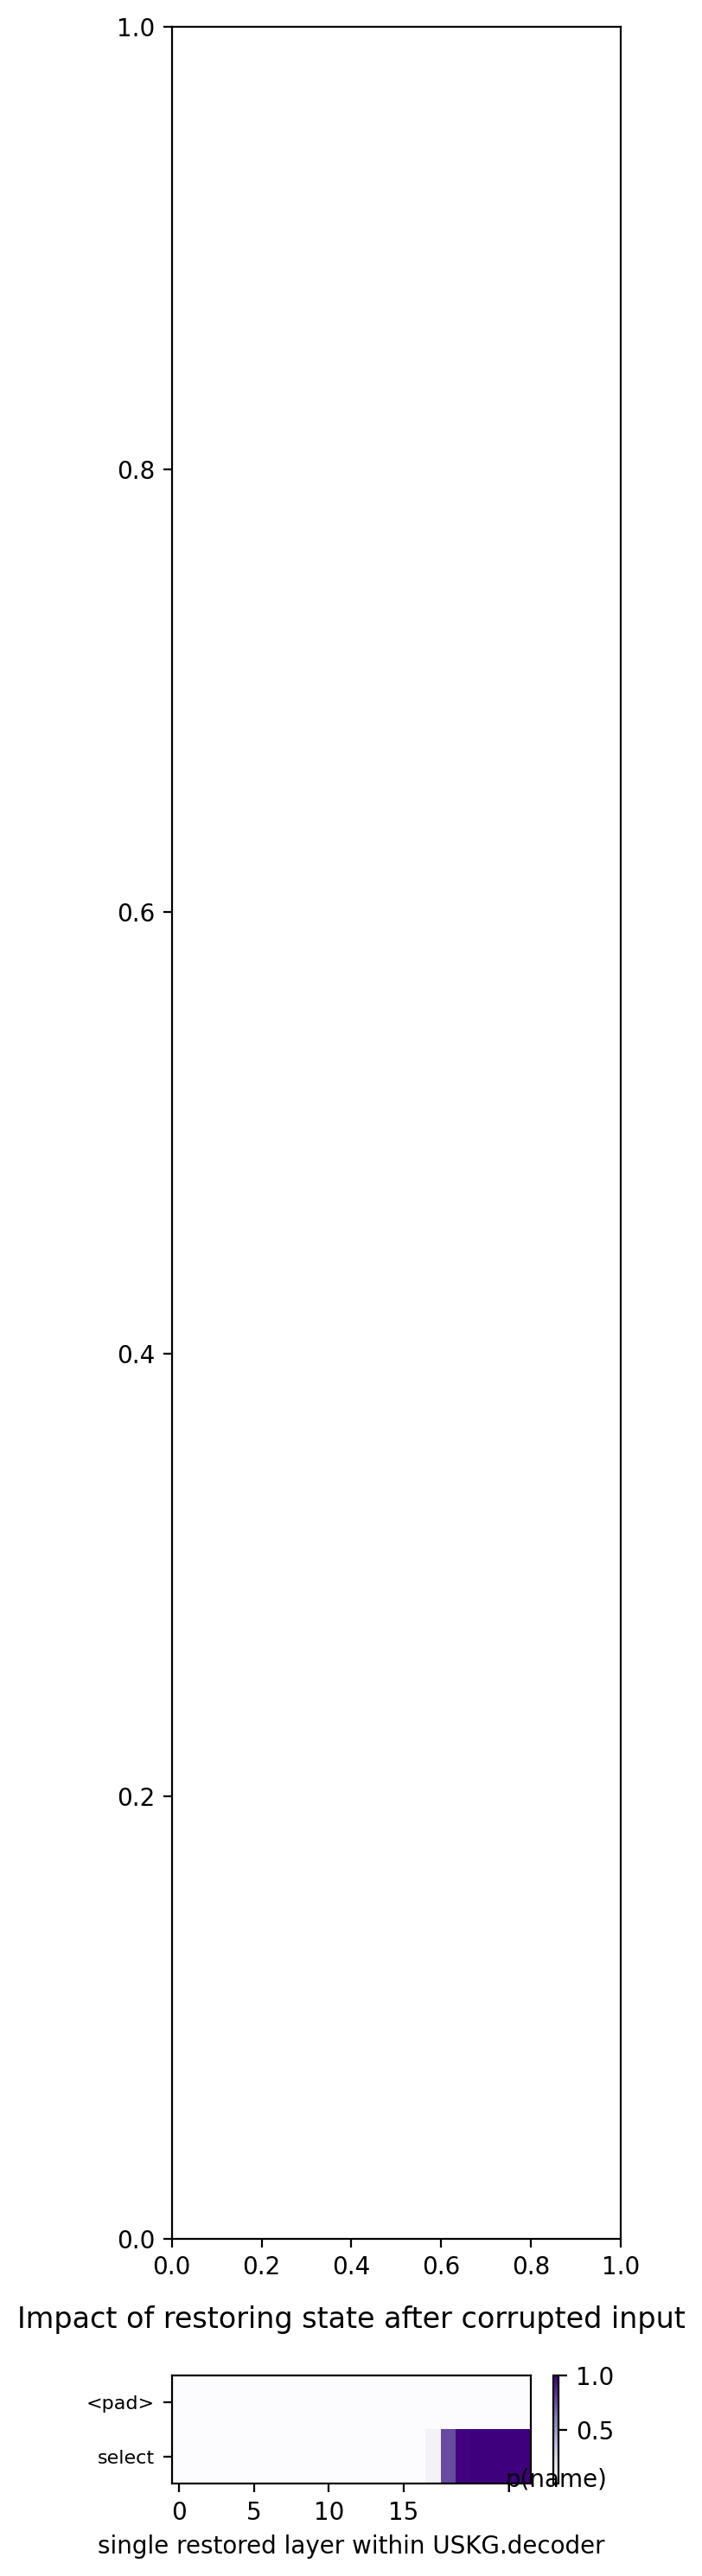

['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.08', '0.77', '0.99', '1.00', '1.00', '1.00', '1.00']


In [331]:
# no sever
ctu.plot_trace_heatmap_t5(result)
print([f"{s:.2f}" for s in result['scores'][1][-1]])

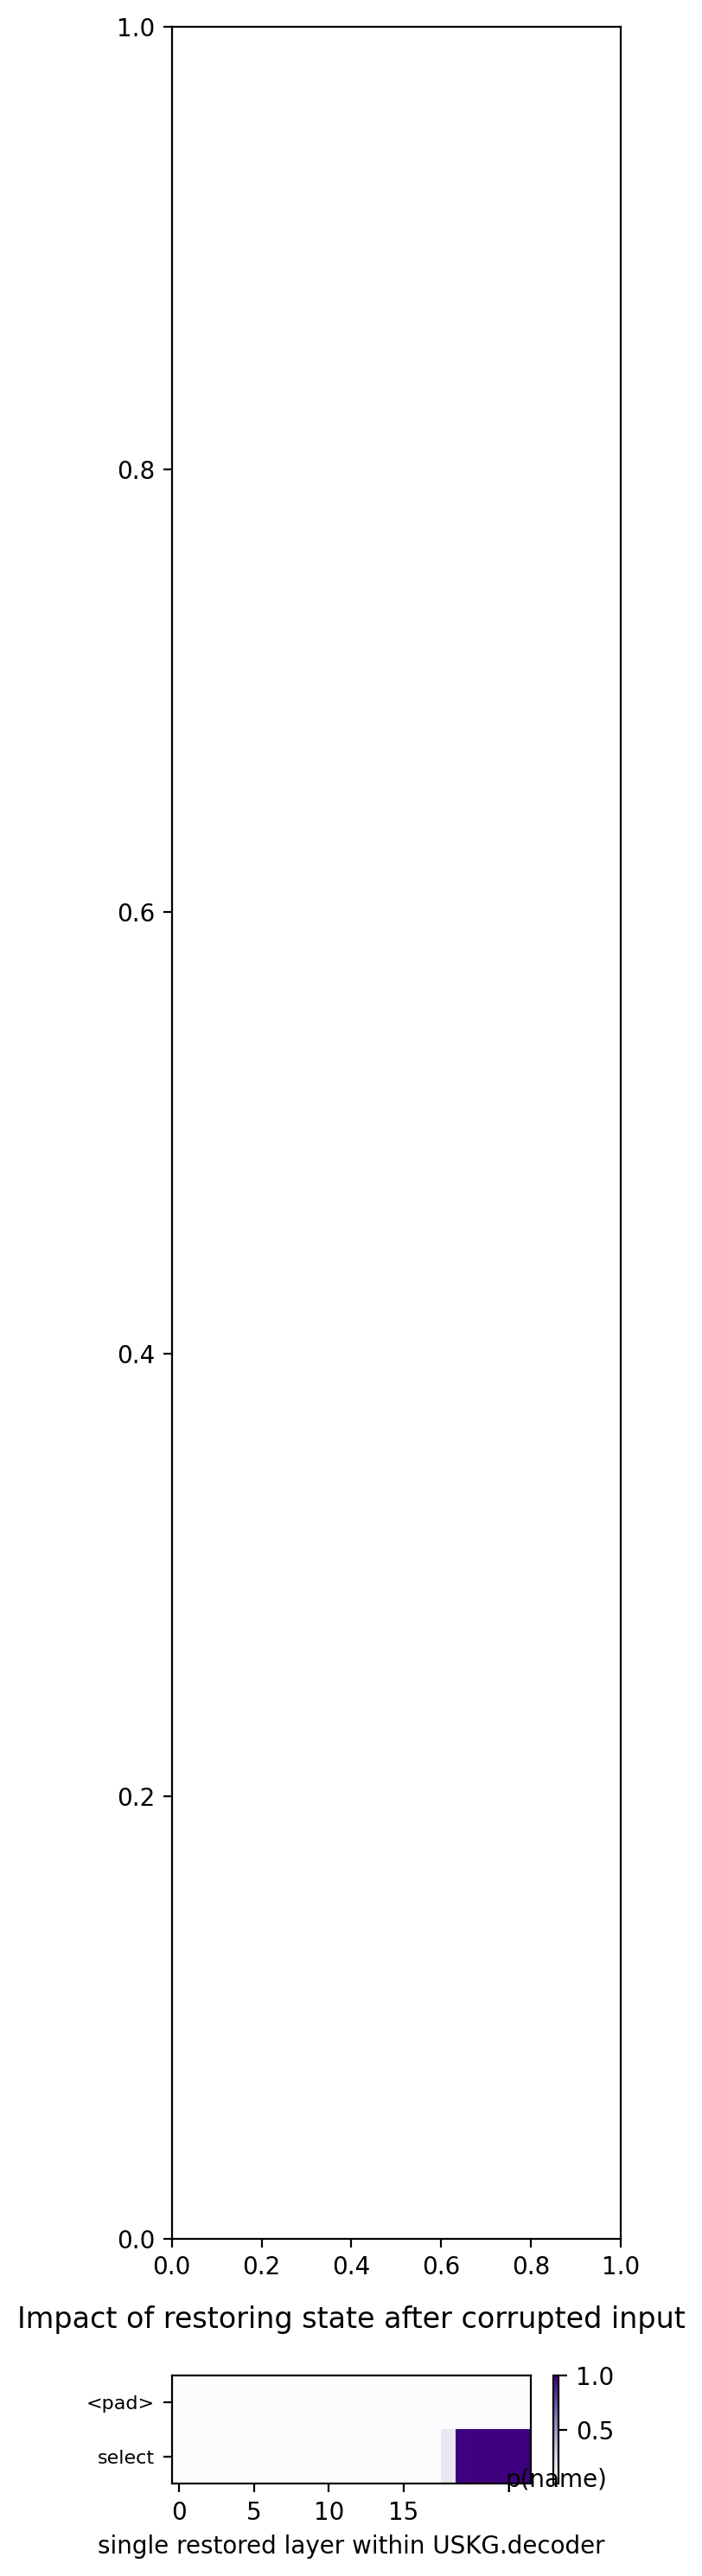

['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.17', '0.99', '1.00', '1.00', '1.00', '1.00']


In [333]:
# sever cross_attn
ctu.plot_trace_heatmap_t5(result)
print([f"{s:.2f}" for s in result['scores'][1][-1]])

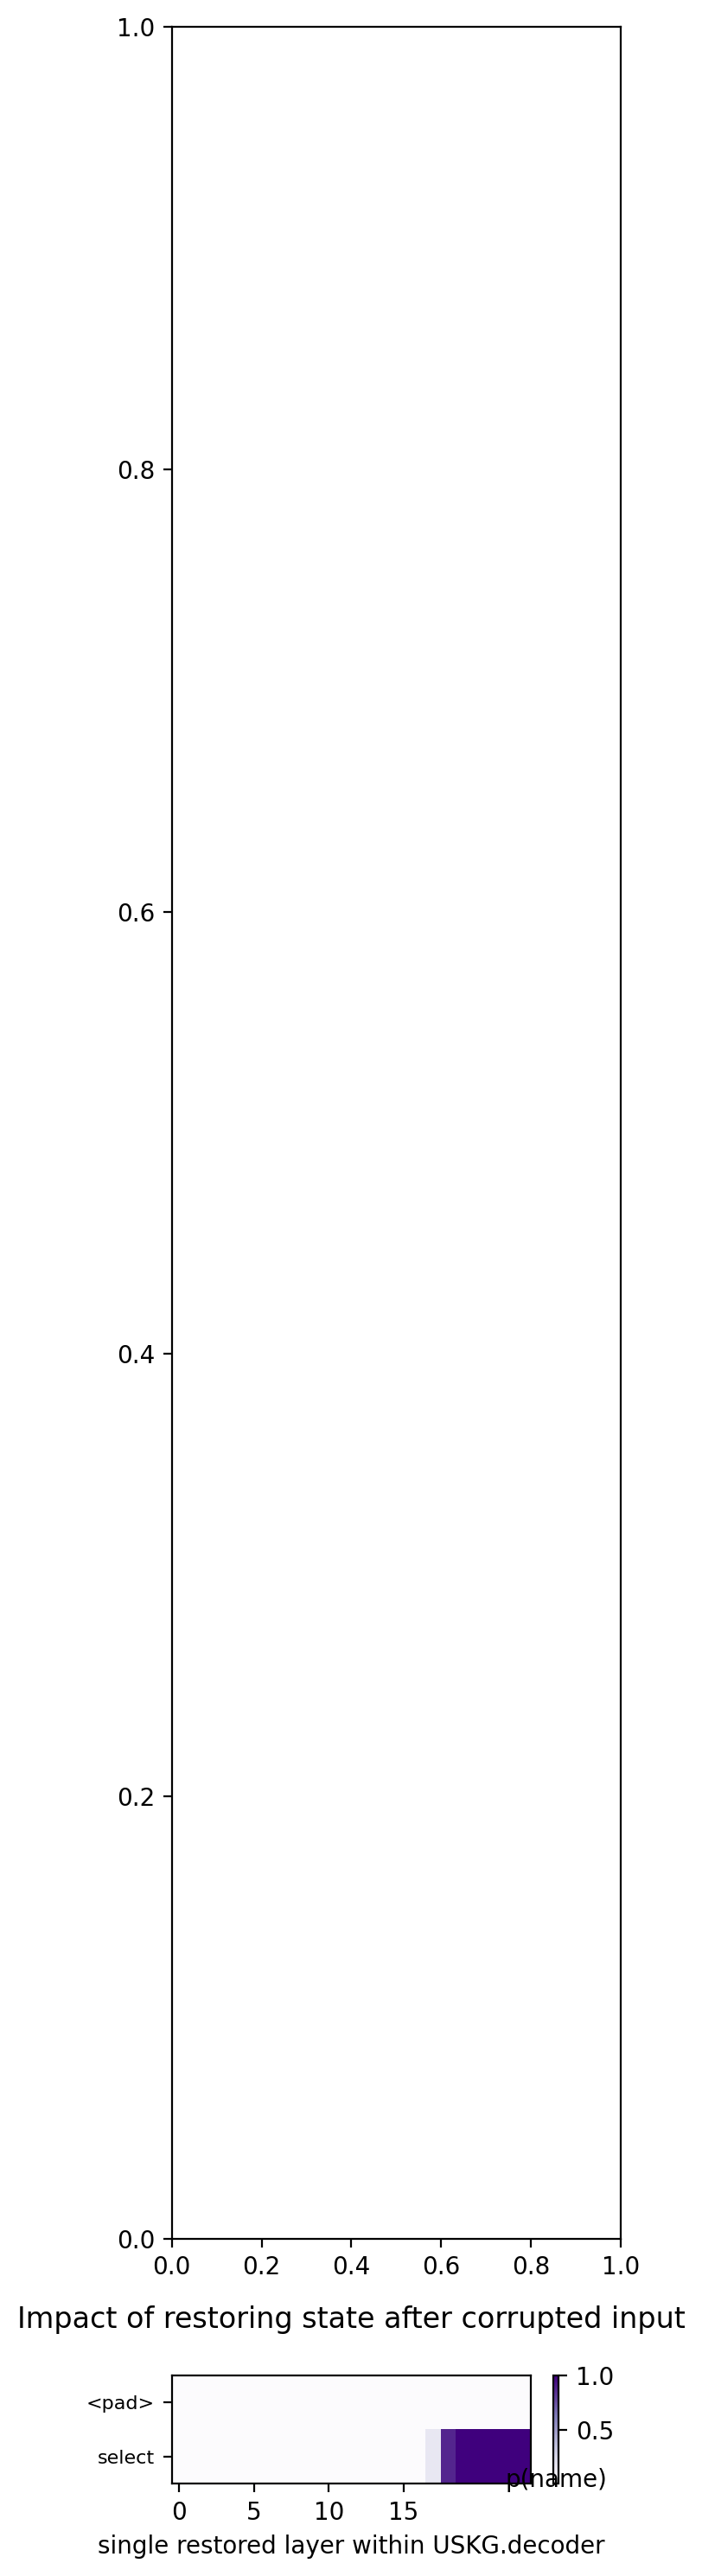

['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.16', '0.88', '1.00', '1.00', '1.00', '1.00', '1.00']


In [335]:
# sever mlp; a bit better than no severing??
ctu.plot_trace_heatmap_t5(result)
print([f"{s:.2f}" for s in result['scores'][1][-1]])

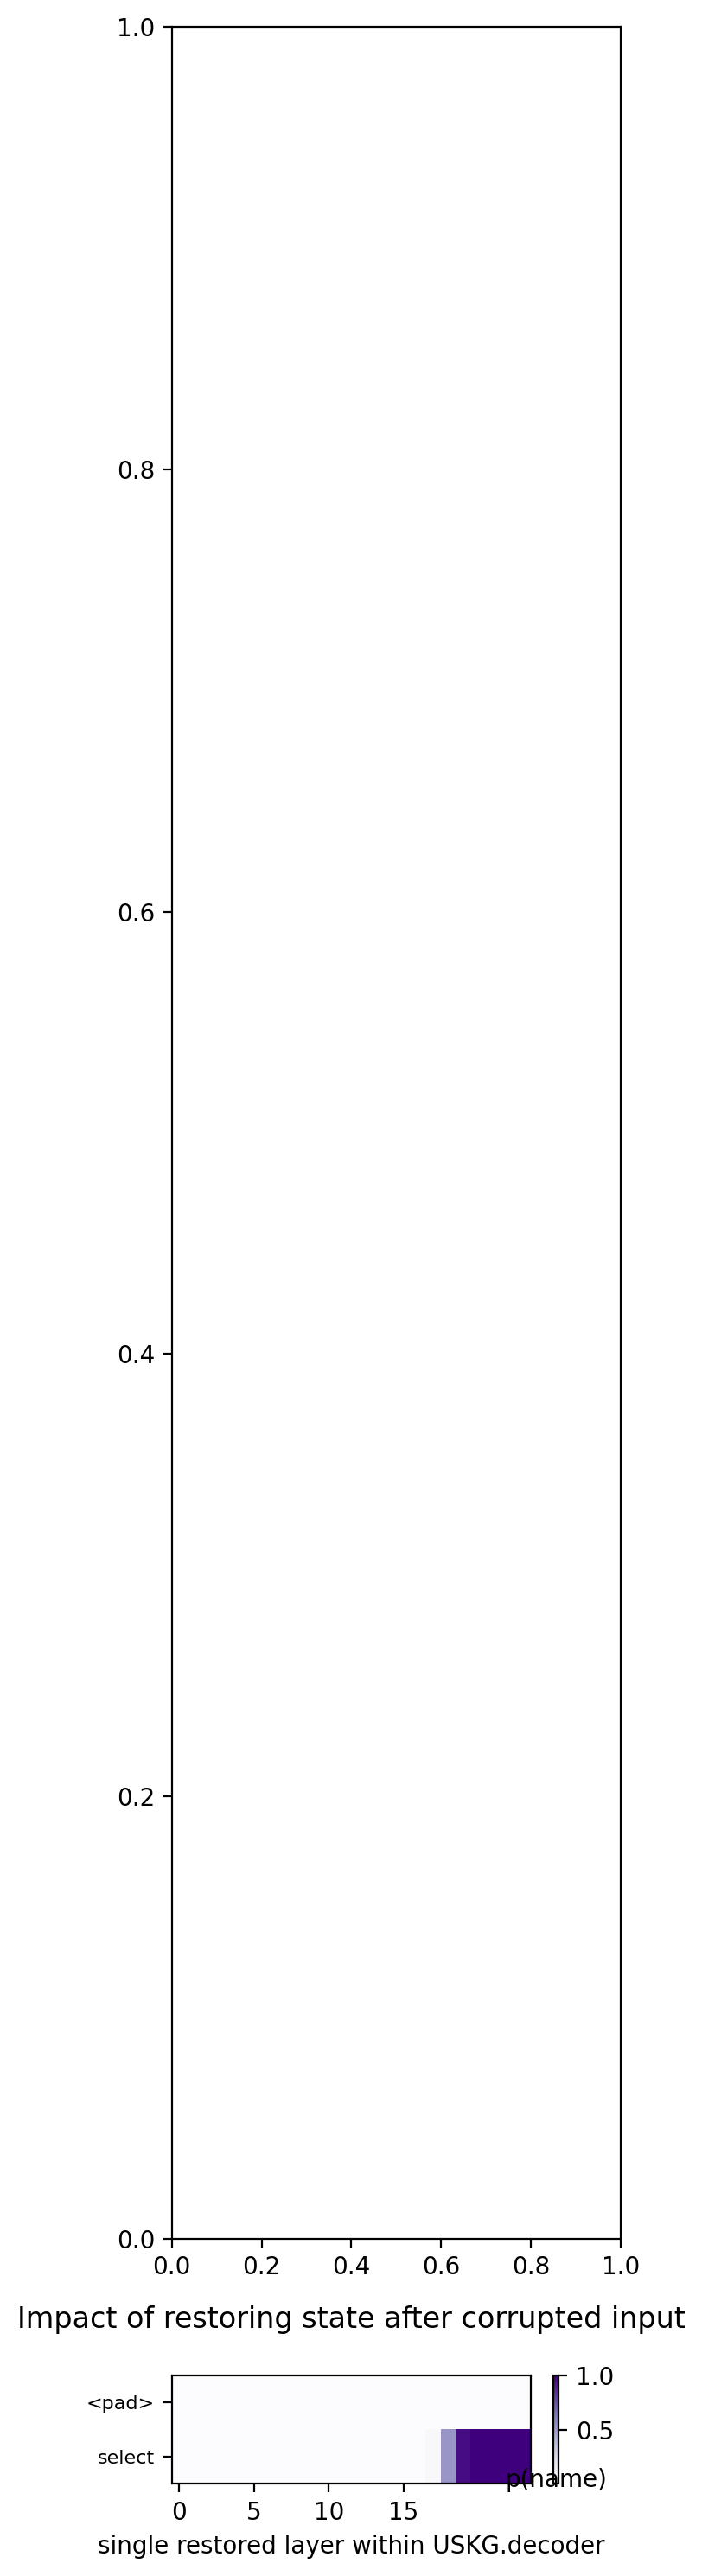

['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.04', '0.52', '0.96', '1.00', '1.00', '1.00', '1.00']


In [337]:
# sever self_attn
ctu.plot_trace_heatmap_t5(result)
print([f"{s:.2f}" for s in result['scores'][1][-1]])

In [338]:
len(result['scores'][1][-1])

24

### Exp-2: dirty text recovery
- Corrupt the text, restore different parts of encoder final output
- Idea is to check the existence of contextual understanding (incorporating text info into struct representation)

#### Single sample
- ID = 2, col = 'name': (name exact match with text)
    - none: wrong; text: correct; struct: correct; col: correct
- ID = 5, col = 'country': (no exact match, but value match with text (French) )
    - none: wrong; text: correct; struct: correct; col: correct
- ID = 145, col = 'year': (no exact match, but value match with text (1980) )
    - none: wrong; text: correct; struct: correct; col: correct
- ID = 7, col = 'song_release_year': (multi-token, and with confusing columns in table (song_name) )
    - none: wrong; text: wrong; struct: correct; col: wrong
    - hypothesis: need clean struct to avoid confusion
- ID = 185, col = 'airportcode': (multi-token, with confusing col (airportname), but have match with text (airport code) )
    - none: wrong; text: correct; struct: wrong (2nd token); col: wrong
    - differs from hypothesis... clean struct should know sql info about the column

In [32]:
_id = 826
ex = processed_spider_dev[_id]
ex['db_id'], ex['question'], ex['struct_in'], ex['seq_out']

('orchestra',
 'What are the names of conductors whose nationalities are not "USA"?',
 '| orchestra | conductor : conductor_id , name , age , nationality ( USA ) , year_of_work | orchestra : orchestra_id , orchestra , conductor_id , record_company , year_of_founded , major_record_format | performance : performance_id , orchestra_id , type , date , official_ratings_(millions) , weekly_rank , share | show : show_id , performance_id , if_first_show , result , attendance',
 "select name from conductor where nationality != 'USA'")

In [33]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
enc_tokenized = mt_uskg.tokenizer(enc_sentence)

text_range, struct_range = ctu.find_text_struct_in_range(mt_uskg.tokenizer, enc_tokenized['input_ids'])
text_range, struct_range

((0, 18), (25, 164))

In [34]:
token_ranges_dict = ctu.find_struct_name_ranges(mt_uskg.tokenizer, enc_tokenized['input_ids'], struct_in)

col_name_ranges = token_ranges_dict['col_name_ranges']

sql_tokens = ctu.separate_punct(ex['seq_out']).split(' ')

sql_cols = set()
for t in sql_tokens:
    if t in col_name_ranges:
        sql_cols.add(t)
sql_cols

{'name', 'nationality'}

In [35]:
parsed_struct_in = ctu.parse_struct_in(struct_in)
parsed_struct_in

((1, 'orchestra', 'orchestra'),
 [((3, 'conductor', 'conductor'),
   [[(5, 'conductor_id', 'conductor_id'), []],
    [(7, 'name', 'name'), []],
    [(9, 'age', 'age'), []],
    [(11, 'nationality', 'nationality ( USA )'), [(13, 'USA', 'USA')]],
    [(16, 'year_of_work', 'year_of_work'), []]]),
  ((18, 'orchestra', 'orchestra'),
   [[(20, 'orchestra_id', 'orchestra_id'), []],
    [(22, 'orchestra', 'orchestra'), []],
    [(24, 'conductor_id', 'conductor_id'), []],
    [(26, 'record_company', 'record_company'), []],
    [(28, 'year_of_founded', 'year_of_founded'), []],
    [(30, 'major_record_format', 'major_record_format'), []]]),
  ((32, 'performance', 'performance'),
   [[(34, 'performance_id', 'performance_id'), []],
    [(36, 'orchestra_id', 'orchestra_id'), []],
    [(38, 'type', 'type'), []],
    [(40, 'date', 'date'), []],
    [(42, 'official_ratings_(millions)', 'official_ratings_(millions)'), []],
    [(44, 'weekly_rank', 'weekly_rank'), []],
    [(46, 'share', 'share'), []]]),

In [37]:
col = 'nationality'
# tok_ranges = token_ranges_dict['col_name_ranges'][col]
# tok_indices = [i for s, e in tok_ranges for i in range(s, e)]
dec_prompt = ctu.make_dec_prompt(ex['seq_out'], col)
expect = col
dec_prompt, expect

('select name from conductor where', 'nationality')

In [38]:
col_toks = token_ranges_dict['col_name_ranges'][col]
col, col_toks

('nationality', [(45, 51)])

In [39]:
# result = ctu.calculate_hidden_flow_uskg(
#     mt_uskg,
#     enc_sentence=enc_sentence,
#     dec_prompt=dec_prompt,
#     expect=col,
#     e_range=text_range,
#     enc_token_range=[],    # no analysis
#     dec_token_range=None,  # full analysis
#     tokens_to_mix_individual_indices=False,
#     replace=True,
#     sever_kind=None,
# )

inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    [enc_sentence] * 11,
    [dec_prompt] * 11,
    answer=expect)

encoder_text_last_layer_states = [
    (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
    for tnum in range(*text_range)
]

encoder_struct_last_layer_states = [
    (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
    for tnum in range(*struct_range)
]

encoder_col_last_layer_states = [
    (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
    for tnum in col_toks
]

answer_len = len(mt_uskg.tokenizer.tokenize(expect))
answers_t, base_score = [d[0] for d in ctu.predict_from_input_uskg_multi_token(mt_uskg.model, inp, pred_len=answer_len)]

In [40]:
base_score

tensor([1.0000, 1.0000], device='cuda:0')

In [41]:
## Corrupting text: expect wrong pred 

all_ans_probs = ctu.trace_with_repatch_uskg_multi_token(
    model=mt_uskg.model,
    inp=inp,
    states_to_patch=[],
    states_to_unpatch=[],
    answers_t=answers_t,
    tokens_to_mix=text_range,
    tokens_to_mix_individual_indices=False,
    replace=True,
)
all_ans_probs, min(all_ans_probs)

([tensor(0.1734, device='cuda:0'), tensor(1.0000, device='cuda:0')],
 tensor(0.1734, device='cuda:0'))

In [42]:
## Restoring text encoding for decoder, but struct encoding are with dirty text encoding 

all_ans_probs = ctu.trace_with_repatch_uskg_multi_token(
    model=mt_uskg.model,
    inp=inp,
    states_to_patch=encoder_text_last_layer_states,
    states_to_unpatch=[],
    answers_t=answers_t,
    tokens_to_mix=text_range,
    tokens_to_mix_individual_indices=False,
    replace=True,
)
all_ans_probs, min(all_ans_probs)

([tensor(1.0000, device='cuda:0'), tensor(0.9999, device='cuda:0')],
 tensor(0.9999, device='cuda:0'))

In [43]:
## Restoring clean struct encoding but dirty text encoding for decoder
## Prediction being correct means encoder final output has "contextual" or "semantic" understanding of struct_in 

all_ans_probs = ctu.trace_with_repatch_uskg_multi_token(
    model=mt_uskg.model,
    inp=inp,
    states_to_patch=encoder_struct_last_layer_states,
    states_to_unpatch=[],
    answers_t=answers_t,
    tokens_to_mix=text_range,
    tokens_to_mix_individual_indices=False,
    replace=True,
)
all_ans_probs, min(all_ans_probs)

([tensor(1.0000, device='cuda:0'), tensor(1., device='cuda:0')],
 tensor(1.0000, device='cuda:0'))

In [44]:
## Restoring clean col_name encoding but dirty text encoding for decoder (stricter than above)

all_ans_probs = ctu.trace_with_repatch_uskg_multi_token(
    model=mt_uskg.model,
    inp=inp,
    states_to_patch=encoder_col_last_layer_states,
    states_to_unpatch=[],
    answers_t=answers_t,
    tokens_to_mix=text_range,
    tokens_to_mix_individual_indices=False,
    replace=True,
)
all_ans_probs, min(all_ans_probs)

([tensor(1.0000, device='cuda:0'), tensor(1.0000, device='cuda:0')],
 tensor(1.0000, device='cuda:0'))

In [45]:
## For exp-2.1: mutual corruption
# First pass: corrupt text (no restore)
# Second pass: corrupt struct, no restore, reset struct output to first pass

all_ans_probs = ctu.trace_with_repatch_uskg_multi_token(
    model=mt_uskg.model,
    inp=inp,
    states_to_patch=[],
    states_to_unpatch=encoder_struct_last_layer_states,
    answers_t=answers_t,
    tokens_to_mix_1st_pass=text_range,
    tokens_to_mix=struct_range,
    tokens_to_mix_individual_indices=False,
    replace=True,
)
all_ans_probs, min(all_ans_probs)

([tensor(1.0000, device='cuda:0'), tensor(1.0000, device='cuda:0')],
 tensor(1.0000, device='cuda:0'))

#### Full dataset analysis
- +exp2.0.1 (finer-grained clean struct)
- +exp2.1 (text-struct-mutual)
- +exp2.1.1 (finer-grained text-struct-mutual 3x3)

In [119]:
out_dir = '/home/yshao/Projects/rome/results/exp2_text_struct_interaction'
os.makedirs(out_dir, exist_ok=True)
res_save_path = os.path.join(out_dir, 'dev_column.jsonl')

In [120]:
total_samples = 0
n_good_samples = 0
n_too_hard = 0      # base score < 0.5
n_too_easy = 0      # base > 0.5, base - low < 0.5

base_scores = []
low_scores = []
restore_scores_dict = {
    'text': [],
    'struct': [],
    'col': [],
    'ctname': [],      # col name + table name (col belongs to) 
    'catname': [],     # col name + all table names 
    'full_table': [],  # full table (col belongs to) 
    'all_col': [],     # all col names (regardless of table)
}


mutual_scores_dict = {
    f'{text}-{struct}': []
    for text in ['clean_t', 'dc_t', 'dirty_t']
    for struct in ['clean_s', 'dc_s', 'dirty_s']
}


In [ ]:
mutual_scores_dict

In [133]:
f = open(res_save_path, 'a')

n_ex = len(processed_spider_dev)
start_id = 0

for ex_id in tqdm(range(start_id, n_ex)):
    ex = processed_spider_dev[ex_id]
    
    text_in = ex['text_in']
    struct_in = ex['struct_in']

    enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
    enc_tokenized = mt_uskg.tokenizer(enc_sentence)

    parsed_struct_in = ctu.parse_struct_in(struct_in)
    col2table = defaultdict(list)
    table2full_range = dict()
    db_id_t, tables = parsed_struct_in
    for table_name_t, cols in tables:
        """ TODO: get and save table full range """
        for col_name_t, vals in cols:
            _, table_name, _ = table_name_t
            _, col_name, _ = col_name_t
            col2table[col_name].append(table_name)
    
    text_range, struct_range = ctu.find_text_struct_in_range(mt_uskg.tokenizer, enc_tokenized['input_ids'])
    token_ranges_dict = ctu.find_struct_name_ranges(mt_uskg.tokenizer, enc_tokenized['input_ids'], struct_in)
    col_name_ranges = token_ranges_dict['col_name_ranges']
    tab_name_ranges = token_ranges_dict['table_name_ranges']

    sql_tokens = ctu.separate_punct(ex['seq_out']).split(' ')
    sql_cols = set()
    for t in sql_tokens:
        if t in col_name_ranges:
            sql_cols.add(t)
    # Update: remove columns appearing multiple times in struct, which may differ from trend of others 
    for t in list(sql_cols):
        if len(col2table[t]) == 0:
            raise ValueError(ex_id, struct_in, t)
        elif len(col2table[t]) > 1:
            sql_cols.remove(t)
    
    ex_results = []
    
    for col in sql_cols:
        total_samples += 1
        
        dec_prompt = ctu.make_dec_prompt(ex['seq_out'], col)
        expect = col
        tab, = col2table[col]    # assert singleton by ","
        col_range, = col_name_ranges[col]
        tab_range, = tab_name_ranges[tab]
        """ TODO: tokens for each setting in 2.0.1 """
        
        result = {
            "text_in": text_in,
            "struct_in": struct_in,
            "seq_out": ex['seq_out'],
            "dec_prompt": dec_prompt,
            "expect": col,
            "table": tab,
            "expect_input_range": col_range,
            # ...
        }

        inp = ctu.make_inputs_t5(
            mt_uskg.tokenizer,
            [enc_sentence] * 11,
            [dec_prompt] * 11,
            answer=expect)

        encoder_text_last_layer_states = [
            (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
            for tnum in range(*text_range)
        ]
        encoder_struct_last_layer_states = [
            (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
            for tnum in range(*struct_range)
        ]
        encoder_col_last_layer_states = [
            (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
            for tnum in range(*col_range)
        ]

        answer_len = len(mt_uskg.tokenizer.tokenize(expect))
        answers_t, base_score = [d[0] for d in ctu.predict_from_input_uskg_multi_token(mt_uskg.model, inp, pred_len=answer_len)]

        base_score = min(base_score).item()
        result['base_score'] = base_score
        if base_score < 0.5:
            n_too_hard += 1
            result['is_good_sample'] = False
            ex_results.append(result)
            continue
        
        ## Corrupting text: expect wrong pred 
        low_score = ctu.trace_with_repatch_uskg(
            model=mt_uskg.model,
            inp=inp,
            states_to_patch=[],
            states_to_unpatch=[],
            answers_t=answers_t,
            tokens_to_mix=text_range,
            tokens_to_mix_individual_indices=False,
            replace=True,
        ).item()
        result['low_score'] = low_score
        
        if base_score - low_score < 0.5:
            n_too_easy += 1
            result['is_good_sample'] = False
            ex_results.append(result)
            continue
        
        n_good_samples += 1
        result['is_good_sample'] = True
        
        ## Restoring text encoding for decoder, but struct encoding are with dirty text encoding 
        r_text_score = ctu.trace_with_repatch_uskg(
            model=mt_uskg.model,
            inp=inp,
            states_to_patch=encoder_text_last_layer_states,
            states_to_unpatch=[],
            answers_t=answers_t,
            tokens_to_mix=text_range,
            tokens_to_mix_individual_indices=False,
            replace=True,
        ).item()
        
        ## Restoring clean struct encoding but dirty text encoding for decoder
        r_struct_score = ctu.trace_with_repatch_uskg(
            model=mt_uskg.model,
            inp=inp,
            states_to_patch=encoder_struct_last_layer_states,
            states_to_unpatch=[],
            answers_t=answers_t,
            tokens_to_mix=text_range,
            tokens_to_mix_individual_indices=False,
            replace=True,
        ).item()
        
        ## Restoring clean col_name encoding but dirty text encoding for decoder (stricter than above)
        r_col_score = ctu.trace_with_repatch_uskg(
            model=mt_uskg.model,
            inp=inp,
            states_to_patch=encoder_col_last_layer_states,
            states_to_unpatch=[],
            answers_t=answers_t,
            tokens_to_mix=text_range,
            tokens_to_mix_individual_indices=False,
            replace=True,
        ).item()
        
        ## For exp-2.1: mutual corruption
        # First pass: corrupt text (no restore)
        # Second pass: corrupt struct, no restore, reset struct output to first pass
        mutual_corrupt_score = ctu.trace_with_repatch_uskg(
            model=mt_uskg.model,
            inp=inp,
            states_to_patch=[],
            states_to_unpatch=encoder_struct_last_layer_states,
            answers_t=answers_t,
            tokens_to_mix_1st_pass=text_range,
            tokens_to_mix=struct_range,
            tokens_to_mix_individual_indices=False,
            replace=True,
        ).item()
        
        result['r_text_score'] = r_text_score
        result['r_struct_score'] = r_struct_score
        result['r_col_score'] = r_col_score
        result['m-dc_t-dc_s-score'] = mutual_corrupt_score
        ex_results.append(result)
        
        base_scores.append(base_score)
        low_scores.append(low_score)
        restore_scores_dict['text'].append(r_text_score)
        restore_scores_dict['struct'].append(r_struct_score)
        restore_scores_dict['col'].append(r_col_score)
        mutual_scores_dict['dc_t-dc_s'].append(mutual_corrupt_score)
        
    ex_out_dict = {
        'ex_id': ex_id,
        'trace_results': ex_results,
    }
    f.write(json.dumps(ex_out_dict, indent=None) + '\n')

f.close()
total_samples, n_good_samples, n_too_hard, n_too_easy

  0%|          | 0/1034 [00:00<?, ?it/s]

(1656, 1287, 3, 365)

In [134]:
col_range

(167, 170)

In [137]:
np.mean(base_scores), np.mean(low_scores), \
np.mean(restore_scores_dict['text']), np.mean(restore_scores_dict['struct']), np.mean(restore_scores_dict['col']), \
np.mean(mutual_scores_dict['dc_t-dc_s'])

(0.9850877505823357,
 0.04326892671237934,
 0.5651500559138737,
 0.8269292973303458,
 0.6717712843135197,
 0.43050430311842003)

In [138]:
print(f'{"Score":25s}avg_gain\tperc_recover')
for score_label, high_scores in [
    ('base_scores', base_scores),
    ('restore_text_scores', restore_scores_dict['text']),
    ('restore_struct_scores', restore_scores_dict['struct']),
    ('restore_col_scores', restore_scores_dict['col']),
    ('mutual_corrupt_scores', mutual_scores_dict['dc_t-dc_s']),
]:
    avg_gain = np.mean([h - l for h, l in zip(high_scores, low_scores)])
    perc_recover = np.mean([h - l > 0.5 for h, l in zip(high_scores, low_scores)])
    print(f'{score_label:25s}{avg_gain:.4f}\t\t{perc_recover:.4f}')

Score                    avg_gain	perc_recover
base_scores              0.9418		1.0000
restore_text_scores      0.5219		0.5470
restore_struct_scores    0.7837		0.8291
restore_col_scores       0.6285		0.6752
mutual_corrupt_scores    0.3872		0.4071


In [139]:
perc_better = np.mean([(h1 - l > 0.5) and (h2 - l < 0.5)
                       for h1, h2, l in zip(restore_struct_scores, restore_text_scores, low_scores)])
perc_worse = np.mean([(h1 - l < 0.5) and (h2 - l > 0.5)
                       for h1, h2, l in zip(restore_struct_scores, restore_text_scores, low_scores)])
perc_both = np.mean([(h1 - l > 0.5) and (h2 - l > 0.5)
                       for h1, h2, l in zip(restore_struct_scores, restore_text_scores, low_scores)])
f'{perc_better:.4f} {perc_worse:.4f} {perc_both:.4f}'

'0.3465 0.0901 0.4631'

In [140]:
import matplotlib.pyplot as plt

(array([246.,  39.,  42.,  45.,  39.,  37.,  53.,  46.,  72., 668.]),
 array([3.45504051e-12, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

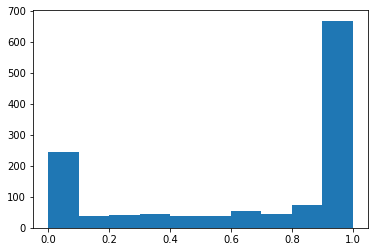

In [141]:
# check scores distribution (clutter at 0 or 1, as expected)
plt.hist(restore_scores_dict['col'])

#### Exp-2.1: (merged above)

In [62]:
# one-time post-processing: add "is_good_sample"=True

# res_tmp_path = os.path.join(out_dir, 'dev_column-tmp.jsonl')
# res_tmp_path, res_save_path

# with open(res_tmp_path, 'r') as f_tmp:
#     all_samples = [json.loads(l) for l in f_tmp]

# with open(res_save_path, 'w') as f:
#     for ex in all_samples:
#         for d in ex['trace_results']:
#             if 'mutual_corrupt_score' in d:
#                 assert d['base_score'] - d['low_score'] > 0.5, d
#                 d['is_good_sample'] = True
#             else:
#                 assert d['is_good_sample'] == False, d
#         f.write(json.dumps(ex) + '\n')
    

#### Split results by hardness

In [142]:
from uskg.third_party.spider import evaluation as sp_eval

In [143]:
table_path = '/home/yshao/Projects/language/language/xsp/data/spider/tables.json'
db_dir = '/home/yshao/Projects/language/language/xsp/data/spider/database'

In [144]:
kmaps = sp_eval.build_foreign_key_map_from_json(table_path)
evaluator = sp_eval.Evaluator(db_dir=db_dir, kmaps=kmaps, etype='match')

In [145]:
_sql_str = 'select t1.birth_date from people as t1 join poker_player as t2 on t1.people_id = t2.people_id order by t2.earnings asc limit 1'
db_name = 'poker_player'
schema = evaluator.schemas[db_name]
_sql = sp_eval.get_sql(schema, _sql_str)
_sql

{'from': {'table_units': [('table_unit', '__people__'),
   ('table_unit', '__poker_player__')],
  'conds': [(False,
    2,
    (0, (0, '__people.people_id__', False), None),
    (0, '__poker_player.people_id__', False),
    None)]},
 'select': (False, [(0, (0, (0, '__people.birth_date__', False), None))]),
 'where': [],
 'groupBy': [],
 'having': [],
 'orderBy': ('asc', [(0, (0, '__poker_player.earnings__', False), None)]),
 'limit': 1,
 'intersect': None,
 'union': None,
 'except': None}

In [146]:
sp_eval.count_component1(_sql), sp_eval.count_component2(_sql), sp_eval.count_others(_sql)

(3, 0, 0)

In [147]:
evaluator.eval_hardness(_sql)

'hard'

In [149]:
# exp2 + exp2.1 
res_path = '/home/yshao/Projects/rome/results/exp2_text_struct_interaction/dev_column.jsonl'

with open(res_path, 'r') as f:
    all_samples = [json.loads(l) for l in f]
len(all_samples)

1034

In [150]:
good_samples = []

for ex in all_samples:
    for d in ex['trace_results']:
        if d['is_good_sample']:
            good_samples.append(d)
len(good_samples)

1287

In [151]:
samples_by_hardness = defaultdict(list)

# for ex in all_samples:
#     for d in ex['trace_results']:
#         if not d['is_good_sample']:
#             continue

for d in good_samples:
    sql_str = d['seq_out']
    db_id = d['struct_in'].split('|')[1].strip()    # TODO: add db_id to result during experiment main run 
    sql = sp_eval.get_sql(evaluator.schemas[db_id], sql_str)
    hardness = evaluator.eval_hardness(sql)
    samples_by_hardness[hardness].append(d)

In [152]:
[(h, len(samples)) for h, samples in samples_by_hardness.items()]

[('medium', 615), ('easy', 214), ('hard', 236), ('extra', 222)]

In [154]:
for h in ['easy', 'medium', 'hard', 'extra']:
    samples = samples_by_hardness[h]
    print(f'Hardness: {h} ({len(samples)})')
    print('[Example sql]', samples[0]['seq_out'])
    print(f'{"Score":25s}avg_gain\tperc_recover')
    
    low_scores = [d['low_score'] for d in samples]
    for score_label in [
        'base_score',
        'r_text_score',
        'r_struct_score',
        'r_col_score',
        'm-dc_t-dc_s-score',
    ]:
        high_scores = [d[score_label] for d in samples]
        avg_gain = np.mean([h - l for h, l in zip(high_scores, low_scores)])
        perc_recover = np.mean([h - l > 0.5 for h, l in zip(high_scores, low_scores)])
        print(f'{score_label:25s}{avg_gain:.4f}\t\t{perc_recover:.4f}')
    print()

Hardness: easy (214)
[Example sql] select distinct country from singer where age > 20
Score                    avg_gain	perc_recover
base_score               0.9505		1.0000
r_text_score             0.6087		0.6542
r_struct_score           0.8407		0.8925
r_col_score              0.6980		0.7477
m-dc_t-dc_s-score        0.4014		0.4252

Hardness: medium (615)
[Example sql] select name, country, age from singer order by age desc
Score                    avg_gain	perc_recover
base_score               0.9461		1.0000
r_text_score             0.5245		0.5561
r_struct_score           0.7910		0.8374
r_col_score              0.6242		0.6699
m-dc_t-dc_s-score        0.3851		0.4098

Hardness: hard (236)
[Example sql] select song_name from singer where age > (select avg(age) from singer)
Score                    avg_gain	perc_recover
base_score               0.9435		1.0000
r_text_score             0.5286		0.5508
r_struct_score           0.7414		0.7712
r_col_score              0.6229		0.6568
m-dc_t-dc_s-

#### Split results by column role

In [155]:
role_keyword_pattern = r'\W(select|where|join|group by|having|order by)\W'

In [156]:
_sql_str = samples_by_hardness['extra'][0]['seq_out']
_sql_str

'select t2.name, t2.capacity from concert as t1 join stadium as t2 on t1.stadium_id = t2.stadium_id where t1.year >= 2014 group by t2.stadium_id order by count(*) desc limit 1'

In [157]:
re.findall(role_keyword_pattern, ' ' + _sql_str + ' ')

['select', 'join', 'where', 'group by', 'order by']

In [158]:
samples_by_column_role = defaultdict(list)

for d in good_samples:
    all_kws = re.findall(role_keyword_pattern, ' ' + d['dec_prompt'] + ' ')
    assert len(all_kws) > 0, d['dec_prompt']
    col_role_kw = all_kws[-1]
    samples_by_column_role[col_role_kw].append(d)

[(r, len(samples)) for r, samples in samples_by_column_role.items()]

[('select', 812),
 ('where', 288),
 ('order by', 80),
 ('join', 103),
 ('having', 3),
 ('group by', 1)]

In [160]:
for r in samples_by_column_role.keys():
    samples = samples_by_column_role[r]
    print(f'Column role: {r} ({len(samples)})')
    print('[Example prompt]', samples[0]['dec_prompt'])
    print(f'{"Score":25s}avg_gain\tperc_recover')
    
    low_scores = [d['low_score'] for d in samples]
    for score_label in [
        'base_score',
        'r_text_score',
        'r_struct_score',
        'r_col_score',
        'm-dc_t-dc_s-score',
    ]:
        high_scores = [d[score_label] for d in samples]
        avg_gain = np.mean([h - l for h, l in zip(high_scores, low_scores)])
        perc_recover = np.mean([h - l > 0.5 for h, l in zip(high_scores, low_scores)])
        print(f'{score_label:25s}{avg_gain:.4f}\t\t{perc_recover:.4f}')
    print()

Column role: select (812)
[Example prompt] select name,
Score                    avg_gain	perc_recover
base_score               0.9596		1.0000
r_text_score             0.5902		0.6182
r_struct_score           0.7531		0.7796
r_col_score              0.6395		0.6786
m-dc_t-dc_s-score        0.4376		0.4618

Column role: where (288)
[Example prompt] select avg(age), min(age), max(age) from singer where
Score                    avg_gain	perc_recover
base_score               0.9137		1.0000
r_text_score             0.4924		0.5243
r_struct_score           0.8361		0.9236
r_col_score              0.7233		0.8021
m-dc_t-dc_s-score        0.3879		0.4271

Column role: order by (80)
[Example prompt] select song_name, song_release_year from singer order by
Score                    avg_gain	perc_recover
base_score               0.9455		1.0000
r_text_score             0.5351		0.5875
r_struct_score           0.9126		0.9625
r_col_score              0.8001		0.8500
m-dc_t-dc_s-score        0.2999		0.3125

Col

## USKG error analysis

In [ ]:
# adapted from play_pred()

def pred_sql(ex):
    text_in = ex['text_in']
    struct_in = ex['struct_in']

    txt = f"{text_in}; structed knowledge: {struct_in}"
    
    tokenized_txt = tokenizer([txt], max_length=1024, padding="max_length", truncation=True)
    
    pred = tokenizer.batch_decode(
      model.generate(
        torch.LongTensor(tokenized_txt.data['input_ids']),
        torch.LongTensor(tokenized_txt.data['attention_mask']),
        num_beams=1, 
        max_length=256
        ), 
      skip_special_tokens=True 
    )
    return pred

In [ ]:
for ex_id, ex in enumerate(tqdm(processed_spider_dev)):
    ex['pred_sql'] = pred_sql(ex)
    

## Temp

### Debugging exp

In [497]:
ex = processed_spider_dev[97]
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = "select t1.model from"
expect = "car_names"

In [498]:
inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    enc_sentences=[enc_sentence]*11,
    dec_prompts=[dec_prompt]*11,
    answer=expect
)

In [499]:
ans_toks = decode_tokens(mt_uskg.tokenizer, mt_uskg.tokenizer.encode(expect, add_special_tokens=False))
ans_toks

['car', '_', 'name', 's']

In [500]:
mt_uskg.tokenizer.decode(inp['decoder_input_ids'][0])

'<pad> select t1.model from car_name'

In [501]:
mt_uskg.tokenizer.tokenize(dec_prompt), len(mt_uskg.tokenizer.tokenize(dec_prompt))

(['▁select', '▁', 't', '1.', 'model', '▁from'], 6)

In [502]:
len(inp['input_ids'][0])

139

In [503]:
# r = ctu.trace_with_patch_uskg_multi_token(
#     mt_uskg.model,
#     inp=inp,
# #     states_to_patch=[(4, ctu.layername_uskg(mt_uskg.model, 'decoder', 3))],
#     states_to_patch=[],
# #     answers_t=mt_uskg.tokenizer.encode(expect, add_special_tokens=False),
# #     tokens_to_mix=(0, len(inp['input_ids'][0])-1),
#     tokens_to_mix=None,
#     replace=True,
# )

In [504]:
# r

[tensor(0.5643, device='cuda:0'),
 tensor(1.0000, device='cuda:0'),
 tensor(0.9996, device='cuda:0'),
 tensor(1.0000, device='cuda:0')]

In [506]:
answer_len = len(mt_uskg.tokenizer.tokenize(expect))
pred_out = ctu.predict_from_input_uskg_multi_token(mt_uskg.model, inp, pred_len=answer_len)
pred, p = pred_out
pred[0]

tensor([ 443,  834, 4350,    7], device='cuda:0')

In [224]:
# pred_toks = decode_tokens(mt_uskg.tokenizer, pred[0])
# list(zip(pred_toks, ans_toks))

[('model', 'car'), ('_', '_'), ('name', 'name'), ('s', 's')]

In [507]:
ex['db_id'], ex['question'], ex['struct_in'], ex['seq_out']

('car_1',
 'Find the model of the car whose weight is below the average weight.',
 '| car_1 | continents : contid , continent | countries : countryid , countryname , continent | car_makers : id , maker , fullname , country | model_list : modelid , maker , model | car_names : makeid , model , make | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year',
 'select t1.model from car_names as t1 join cars_data as t2 on t1.makeid = t2.id where t2.weight < (select avg(weight) from cars_data)')

In [510]:
r = ctu.trace_with_repatch_uskg_multi_token(
    mt_uskg.model,
    inp=inp,
    states_to_patch=[(4, ctu.layername_uskg(mt_uskg.model, 'decoder', 3))],
    states_to_unpatch=[(4, ctu.layername_uskg(mt_uskg.model, 'decoder', 4, 'cross_attn'))],
    states_to_patch_1st_pass=[(4, ctu.layername_uskg(mt_uskg.model, 'decoder', l)) for l in range(mt_uskg.num_enc_layers)],
    answers_t=pred[0],
    tokens_to_mix=(10, 20, 30, 40),
    tokens_to_mix_1st_pass=(5, 15, 25),
    tokens_to_mix_individual_indices=True,
    replace=True,
)

* 1st pass, layer: pretrain_model.encoder.embed_tokens, corrupting: (5, 15, 25)
* 1st pass, layer: pretrain_model.decoder.block.0, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.1, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.2, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.3, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.4, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.5, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.6, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.7, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.8, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.9, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.10, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.11, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.12, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.13, restori

In [511]:
r

[tensor(0.5877, device='cuda:0'),
 tensor(1., device='cuda:0'),
 tensor(0.9988, device='cuda:0'),
 tensor(1.0000, device='cuda:0')]

### Moving models

In [82]:
mt_uskg.model.device

device(type='cpu')

### tokenizer

In [11]:
tokenizer = mt_uskg.tokenizer

In [433]:
s = "mary: has a little  lambbb"
s_ = "mary: has a little lambbb"
tokenizer.tokenize(s), tokenizer.tokenize(s_)

(['▁mar', 'y', ':', '▁has', '▁', 'a', '▁little', '▁lamb', 'b', 'b'],
 ['▁mar', 'y', ':', '▁has', '▁', 'a', '▁little', '▁lamb', 'b', 'b'])

In [428]:
t = tokenizer(s)
t

{'input_ids': [3157, 63, 10, 65, 3, 9, 385, 17871, 115, 115, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [429]:
list(enumerate(t.tokens()))

[(0, '▁mar'),
 (1, 'y'),
 (2, ':'),
 (3, '▁has'),
 (4, '▁'),
 (5, 'a'),
 (6, '▁little'),
 (7, '▁lamb'),
 (8, 'b'),
 (9, 'b'),
 (10, '</s>')]

In [430]:
t.word_to_tokens(4)

TokenSpan(start=7, end=10)

In [431]:
ctu.decode_sentences(tokenizer, t['input_ids'][7:10])

'lambbb'

In [ ]:
"(a(a)a)".rindex(")"), "(a(a)a)".index(")")

### Test struct_in parsing

In [66]:
_struct_in = """| concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , \
average | singer : singer_id , name ( First Last ) , country ( France , Germany , United States ) , \
song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , \
stadium_id , year ( 2008 , 2012 , 2022 ) | singer_in_concert : concert_id , singer_id"""

In [71]:
ctu.parse_struct_in(_struct_in)

[((3, 'stadium'),
  [[(5, 'stadium_id'), []],
   [(7, 'location'), []],
   [(9, 'name'), []],
   [(11, 'capacity'), []],
   [(13, 'highest'), []],
   [(15, 'lowest'), []],
   [(17, 'average'), []]]),
 ((19, 'singer'),
  [[(21, 'singer_id'), []],
   [(23, 'name'), [(25, 'First Last')]],
   [(29, 'country'), [(31, 'France'), (33, 'Germany'), (35, 'United States')]],
   [(39, 'song_name'), []],
   [(41, 'song_release_year'), []],
   [(43, 'age'), []],
   [(45, 'is_male'), []]]),
 ((47, 'concert'),
  [[(49, 'concert_id'), []],
   [(51, 'concert_name'), []],
   [(53, 'theme'), []],
   [(55, 'stadium_id'), []],
   [(57, 'year'), [(59, '2008'), (61, '2012'), (63, '2022')]]]),
 ((66, 'singer_in_concert'),
  [[(68, 'concert_id'), []], [(70, 'singer_id'), []]])]

In [84]:
_text_in = text_in

enc_sentence = f"{_text_in}; structed knowledge: {_struct_in}"
enc_tokenized = mt_uskg.tokenizer(enc_sentence)

In [85]:
token_ranges_dict = ctu.find_struct_name_ranges(mt_uskg.tokenizer, enc_tokenized['input_ids'], _struct_in)

In [86]:
token_ranges_dict

{'db_id_ranges': defaultdict(list, {'concert_singer': [(25, 29)]}),
 'table_name_ranges': defaultdict(list,
             {'stadium': [(30, 31)],
              'singer': [(56, 57)],
              'concert': [(106, 107)],
              'singer_in_concert': [(142, 149)]}),
 'col_name_ranges': defaultdict(list,
             {'stadium_id': [(33, 37), (123, 127)],
              'location': [(39, 40)],
              'name': [(42, 43), (65, 66)],
              'capacity': [(45, 46)],
              'highest': [(48, 49)],
              'lowest': [(51, 52)],
              'average': [(54, 55)],
              'singer_id': [(59, 63), (157, 161)],
              'country': [(73, 74)],
              'song_name': [(87, 90)],
              'song_release_year': [(92, 97)],
              'age': [(99, 100)],
              'is_male': [(102, 105)],
              'concert_id': [(109, 113), (151, 155)],
              'concert_name': [(115, 118)],
              'theme': [(120, 121)],
              'year': [(129

In [161]:
for d_key, d in token_ranges_dict.items():
    for name, ranges in d.items():
        for s, e in ranges:
            recs_name = ctu.decode_sentences(mt_uskg.tokenizer, enc_tokenized['input_ids'][s:e])
            print(f'{d_key}\t{name}\t{recs_name}')

db_id_ranges	concert_singer	concert_singer
table_name_ranges	stadium	stadium
table_name_ranges	singer	singer
table_name_ranges	concert	concert
table_name_ranges	singer_in_concert	singer_in_concert
col_name_ranges	stadium_id	stadium_id
col_name_ranges	stadium_id	stadium_id
col_name_ranges	location	location
col_name_ranges	name	name
col_name_ranges	name	name
col_name_ranges	capacity	capacity
col_name_ranges	highest	highest
col_name_ranges	lowest	lowest
col_name_ranges	average	average
col_name_ranges	singer_id	singer_id
col_name_ranges	singer_id	singer_id
col_name_ranges	country	country ( France )
col_name_ranges	song_name	song_name
col_name_ranges	song_release_year	song_release_year
col_name_ranges	age	age
col_name_ranges	is_male	is_male
col_name_ranges	concert_id	concert_id
col_name_ranges	concert_id	concert_id
col_name_ranges	concert_name	concert_name
col_name_ranges	theme	theme
col_name_ranges	year	year
val_name_ranges	France	France


### other temp

In [143]:
!pip show matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Name: matplotlib
Version: 3.5.1
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /home/yshao/anaconda3/envs/rome/lib/python3.9/site-packages
Requires: packaging, fonttools, python-dateutil, kiwisolver, numpy, pillow, pyparsing, cycler
Required-by: 


In [196]:
type(mt_uskg.model.pretrain_model.shared.weight)

torch.nn.parameter.Parameter

In [198]:
_emb = mt_uskg.model.pretrain_model.shared.weight.clone()
type(_emb)

torch.Tensor

In [202]:
_emb is mt_uskg.model.pretrain_model.shared.weight

False

In [203]:
_ref = mt_uskg.model.pretrain_model.shared.weight
_ref is mt_uskg.model.pretrain_model.shared.weight

True

In [194]:
m = mt_uskg.model.pretrain_model

In [196]:
m.encoder.embed_tokens.weight.size()

torch.Size([32102, 1024])

In [226]:
m.decoder.embed_tokens = copy.deepcopy(m.encoder.embed_tokens)

In [ ]:
[k for k,v in m.named_modules()]

In [322]:
mt_uskg.tokenizer.tokenize('as t1')

['▁as', '▁', 't', '1']

In [328]:
ex = processed_spider_dev[4]

In [329]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = "select t1.model from car_names as t1 join cars_"
expect = "data"

inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    enc_sentences=[enc_sentence],
    dec_prompts=[dec_prompt],
    device="cuda:0"
)
out = ctu.run_model_forward_uskg(mt_uskg.model, **inp)
logits = out["logits"][0, -1].detach().cpu().numpy()

top_5 = sorted(list(enumerate(logits)), key=lambda p: -p[1])[:5]

[(mt_uskg.tokenizer.decode([p[0]]), p[1]) for p in top_5]


[('in', -3.781785),
 ('s', -7.1667466),
 ('in', -11.278912),
 ('for', -11.461598),
 ('and', -11.540182)]

In [365]:
[k for k,v in mt_uskg.model.named_modules()]

['',
 'pretrain_model',
 'pretrain_model.shared',
 'pretrain_model.encoder',
 'pretrain_model.encoder.block',
 'pretrain_model.encoder.block.0',
 'pretrain_model.encoder.block.0.layer',
 'pretrain_model.encoder.block.0.layer.0',
 'pretrain_model.encoder.block.0.layer.0.SelfAttention',
 'pretrain_model.encoder.block.0.layer.0.SelfAttention.q',
 'pretrain_model.encoder.block.0.layer.0.SelfAttention.k',
 'pretrain_model.encoder.block.0.layer.0.SelfAttention.v',
 'pretrain_model.encoder.block.0.layer.0.SelfAttention.o',
 'pretrain_model.encoder.block.0.layer.0.SelfAttention.relative_attention_bias',
 'pretrain_model.encoder.block.0.layer.0.layer_norm',
 'pretrain_model.encoder.block.0.layer.0.dropout',
 'pretrain_model.encoder.block.0.layer.1',
 'pretrain_model.encoder.block.0.layer.1.DenseReluDense',
 'pretrain_model.encoder.block.0.layer.1.DenseReluDense.wi',
 'pretrain_model.encoder.block.0.layer.1.DenseReluDense.wo',
 'pretrain_model.encoder.block.0.layer.1.DenseReluDense.dropout',
 'p

In [183]:
a = torch.eye(3, device="cpu")
b = torch.eye(2, dtype=float, device="cuda:0")
b.to(device=a.device, dtype=a.dtype)

tensor([[1., 0.],
        [0., 1.]])

In [184]:
a[1:, [0, 2]] = b.to(device=a.device, dtype=a.dtype)
a

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [0., 0., 1.]])

In [192]:
mt_uskg.tokenizer.encode('t1', add_special_tokens=False)

[3, 17, 536]

In [57]:
val_split_pattern = r'\([^\)]*?\s,\s.*?\)'
l = list(re.finditer(val_split_pattern, _struct_in))
l

[<re.Match object; span=(151, 187), match='( France , Germany , United States )'>,
 <re.Match object; span=(303, 325), match='( 2008 , 2012 , 2022 )'>]

In [63]:
l[0].span()


(151, 187)

In [282]:
_sql = "select avg(t1.age), is_male from singer where country = '%land%'"

In [283]:
ctu.separate_punct(_sql)

"select avg ( t1 . age ) , is_male from singer where country = ' % land % '"

In [125]:
x = re.search(r'\W(abcde)\W', 't1.abcde ')
x

<re.Match object; span=(2, 9), match='.abcde '>

In [132]:
x.span(1)

(3, 8)

In [123]:
mt_uskg.tokenizer.tokenize("select avg ( age )"), \
mt_uskg.tokenizer.tokenize("select avg(age)")

(['▁select', '▁', 'a', 'v', 'g', '▁(', '▁age', '▁', ')'],
 ['▁select', '▁', 'a', 'v', 'g', '(', 'age', ')'])

In [248]:
[d for d in res_dicts if not d['trace_results']]

[{'ex_id': 0, 'trace_results': []},
 {'ex_id': 1, 'trace_results': []},
 {'ex_id': 22, 'trace_results': []},
 {'ex_id': 23, 'trace_results': []},
 {'ex_id': 24, 'trace_results': []},
 {'ex_id': 25, 'trace_results': []},
 {'ex_id': 33, 'trace_results': []},
 {'ex_id': 34, 'trace_results': []},
 {'ex_id': 35, 'trace_results': []},
 {'ex_id': 36, 'trace_results': []},
 {'ex_id': 37, 'trace_results': []},
 {'ex_id': 38, 'trace_results': []},
 {'ex_id': 41, 'trace_results': []},
 {'ex_id': 42, 'trace_results': []},
 {'ex_id': 51, 'trace_results': []},
 {'ex_id': 52, 'trace_results': []},
 {'ex_id': 53, 'trace_results': []},
 {'ex_id': 54, 'trace_results': []},
 {'ex_id': 57, 'trace_results': []},
 {'ex_id': 58, 'trace_results': []},
 {'ex_id': 59, 'trace_results': []},
 {'ex_id': 60, 'trace_results': []},
 {'ex_id': 65, 'trace_results': []},
 {'ex_id': 66, 'trace_results': []},
 {'ex_id': 75, 'trace_results': []},
 {'ex_id': 76, 'trace_results': []},
 {'ex_id': 77, 'trace_results': []},
 {'

In [250]:
processed_spider_dev[22]['seq_out']

'select t2.name, count(*) from concert as t1 join stadium as t2 on t1.stadium_id = t2.stadium_id group by t1.stadium_id'

In [295]:
torch.tensor([])

tensor([])

In [131]:
a, b = [(1, 2)]
a

ValueError: not enough values to unpack (expected 2, got 1)

In [132]:
a, = [(1, 2)]
a

(1, 2)